EDA
---

This notebook takes the tweet and user results gathered and cleaned after the [data cleaning](./2_data_cleanup.ipynb) step and performs an exploration. 

It first merges the tweets and users dataframes, addresses null values, and drops duplicates.

It identifies the user location, tweet language, and linked Wordle variant as features to train a neural network on. It also makes some steps in showing the rates of tweet posts. At some points it takes an aside to make dictionaries that will be used in the preprocessing stage.

# Setup

### Import libraries

In [129]:
import pandas as pd
import numpy as np
import os
import json
import ast
import datetime as dt
import re

from datetime import datetime
from dateutil import tz

#use this to find union of multiple lists
from functools import reduce

#plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

#pandas options
pd.options.display.max_columns = 100

plt.style.use('default')

merged_data_path = './merged_data/'

%matplotlib inline

### Import data

In [130]:
#low_memory = False is to deal with mixed column types.
tweets = pd.read_csv(merged_data_path + 'merged_tweets.csv', low_memory = False)
users = pd.read_csv(merged_data_path + 'merged_users.csv', low_memory = False)

In [131]:
# look at tweets dataframe info
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335327 entries, 0 to 335326
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   335327 non-null  int64  
 1   conversation_id      335327 non-null  int64  
 2   reply_settings       335327 non-null  object 
 3   lang                 335327 non-null  object 
 4   entities             107512 non-null  object 
 5   possibly_sensitive   335327 non-null  bool   
 6   source               335327 non-null  object 
 7   public_metrics       335327 non-null  object 
 8   text                 335327 non-null  object 
 9   context_annotations  331475 non-null  object 
 10  author_id            335327 non-null  int64  
 11  created_at           335327 non-null  object 
 12  referenced_tweets    35202 non-null   object 
 13  in_reply_to_user_id  32555 non-null   float64
 14  attachments          4130 non-null    object 
 15  geo              

In [132]:
# look at top of tweets dataframe
tweets.head()

,id,conversation_id,reply_settings,lang,entities,possibly_sensitive,source,public_metrics,text,context_annotations,author_id,created_at,referenced_tweets,in_reply_to_user_id,attachments,geo,withheld
0,1521733018293084160,1521733018293084160,everyone,en,"{'urls': [{'start': 54, 'end': 77, 'url': 'htt...",False,Twitter Web App,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Wordle (ES) #118 5/6\n\n⬜⬜🟨🟩⬜\n⬜⬜🟨🟩⬜\n⬜⬜⬜🟩🟩\n...,"[{'domain': {'id': '30', 'name': 'Entities [En...",1006110502043471872,2022-05-04 06:06:38+00:00,NaN,NaN,NaN,NaN,NaN
1,1521733015738662913,1521733015738662913,everyone,es,"{'urls': [{'start': 58, 'end': 81, 'url': 'htt...",False,Twitter for Android,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Wordle Científico #52 5/6\n\n⬜⬜⬜⬜🟨\n🟨⬜⬜⬜🟩\n⬜🟩⬜...,"[{'domain': {'id': '30', 'name': 'Entities [En...",360002014,2022-05-04 06:06:38+00:00,NaN,NaN,NaN,NaN,NaN
2,1521733011414257664,1521733011414257664,everyone,en,NaN,False,Twitter for Android,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Wordle 319 4/6\n\n🟨🟨⬜⬜⬜\n🟨⬜⬜🟩⬜\n🟩🟨⬜🟩🟨\n🟩🟩🟩🟩🟩,"[{'domain': {'id': '30', 'name': 'Entities [En...",828818052892422148,2022-05-04 06:06:37+00:00,NaN,NaN,NaN,NaN,NaN
3,1521733010504445954,1521733010504445954,everyone,en,NaN,False,Twitter for Android,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Back in the saddle.\n\nWordle 319 3/6\n\n⬜🟩⬜🟨⬜...,"[{'domain': {'id': '30', 'name': 'Entities [En...",862077942,2022-05-04 06:06:36+00:00,NaN,NaN,NaN,NaN,NaN
4,1521733001981444096,1521731925559418880,everyone,en,"{'mentions': [{'start': 0, 'end': 12, 'usernam...",False,Twitter for iPhone,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",@RwellsWells Same. Are we both spotters? Haha ...,"[{'domain': {'id': '30', 'name': 'Entities [En...",53116513,2022-05-04 06:06:34+00:00,"[{'type': 'replied_to', 'id': '152173192555941...",331622540.0,NaN,NaN,NaN


In [133]:
# set tweets index to tweet id
tweets.set_index('id', inplace = True)

In [134]:
# look at users info and top of dataframe
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147313 entries, 0 to 147312
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 147313 non-null  int64  
 1   name               147306 non-null  object 
 2   public_metrics     147313 non-null  object 
 3   url                44780 non-null   object 
 4   description        129085 non-null  object 
 5   profile_image_url  147313 non-null  object 
 6   location           105401 non-null  object 
 7   protected          147313 non-null  bool   
 8   username           147313 non-null  object 
 9   verified           147313 non-null  bool   
 10  entities           62081 non-null   object 
 11  pinned_tweet_id    68630 non-null   float64
 12  withheld           1 non-null       object 
dtypes: bool(2), float64(1), int64(1), object(9)
memory usage: 12.6+ MB


In [135]:
users.head()

,id,name,public_metrics,url,description,profile_image_url,location,protected,username,verified,entities,pinned_tweet_id,withheld
0,1006110502043471872,Jose Antonio,"{'followers_count': 147, 'following_count': 43...",NaN,"Antiguo usuario bloqueado por error, pero he v...",https://pbs.twimg.com/profile_images/144681186...,"Alcalá de Guadaíra, Spain",False,Joseamj_97,False,NaN,NaN,NaN
1,360002014,Ana V Garcia,"{'followers_count': 41, 'following_count': 136...",https://t.co/uMfikCmd0I,NaN,https://pbs.twimg.com/profile_images/122215871...,Alcalá de Henares,False,AnaVGarciaG,False,"{'url': {'urls': [{'start': 0, 'end': 23, 'url...",NaN,NaN
2,828818052892422144,Braden Van't Hof,"{'followers_count': 8, 'following_count': 282,...",NaN,LoL Head Coach/Manager/Mid Laner/4x Positional...,https://pbs.twimg.com/profile_images/149527273...,"Grand Rapids, MI",False,CLVRockmelon,False,NaN,NaN,NaN
3,862077942,John Milton ✊,"{'followers_count': 1465, 'following_count': 2...",https://t.co/iOfRLxEru5,"It's not criticism, it's just a different way ...",https://pbs.twimg.com/profile_images/150123920...,Spain,False,Geordioca,False,"{'url': {'urls': [{'start': 0, 'end': 23, 'url...",NaN,NaN
4,53116513,christopher jones,"{'followers_count': 189, 'following_count': 26...",NaN,I don't like cricket. oh no. i love it!,https://pbs.twimg.com/profile_images/110881711...,sheffield,False,chrisjones792,False,NaN,NaN,NaN


In [136]:
# set user index to user id
users.set_index('id', inplace = True)

## Address null values

### tweets

In [137]:
#pick out tweets columns with any null values
tweets.loc[:, tweets.isna().any()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335327 entries, 1521733018293084160 to 1521994876677672966
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   entities             107512 non-null  object 
 1   context_annotations  331475 non-null  object 
 2   referenced_tweets    35202 non-null   object 
 3   in_reply_to_user_id  32555 non-null   float64
 4   attachments          4130 non-null    object 
 5   geo                  5333 non-null    object 
 6   withheld             4 non-null       object 
dtypes: float64(1), object(6)
memory usage: 20.5+ MB


In [138]:
#look at these columns
tweets.loc[:, tweets.isna().any()].head(4)

,entities,context_annotations,referenced_tweets,in_reply_to_user_id,attachments,geo,withheld
id,,,,,,,
1521733018293084160,"{'urls': [{'start': 54, 'end': 77, 'url': 'htt...","[{'domain': {'id': '30', 'name': 'Entities [En...",NaN,NaN,NaN,NaN,NaN
1521733015738662913,"{'urls': [{'start': 58, 'end': 81, 'url': 'htt...","[{'domain': {'id': '30', 'name': 'Entities [En...",NaN,NaN,NaN,NaN,NaN
1521733011414257664,NaN,"[{'domain': {'id': '30', 'name': 'Entities [En...",NaN,NaN,NaN,NaN,NaN
1521733010504445954,NaN,"[{'domain': {'id': '30', 'name': 'Entities [En...",NaN,NaN,NaN,NaN,NaN


In [139]:
#show some non-NaN `referenced_tweets` to see what they ought to look like
tweets[[ not tweet for tweet in tweets['referenced_tweets'].isna()]].head(4)

,conversation_id,reply_settings,lang,entities,possibly_sensitive,source,public_metrics,text,context_annotations,author_id,created_at,referenced_tweets,in_reply_to_user_id,attachments,geo,withheld
id,,,,,,,,,,,,,,,,
1521733001981444096,1521731925559418880,everyone,en,"{'mentions': [{'start': 0, 'end': 12, 'usernam...",False,Twitter for iPhone,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",@RwellsWells Same. Are we both spotters? Haha ...,"[{'domain': {'id': '30', 'name': 'Entities [En...",53116513,2022-05-04 06:06:34+00:00,"[{'type': 'replied_to', 'id': '152173192555941...",3.316225e+08,NaN,NaN,NaN
1521732989977305088,1493048111366877185,everyone,en,"{'mentions': [{'start': 0, 'end': 16, 'usernam...",False,Twitter Web App,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",@misfortunateApe @SamuelAlpha77 @1kisfud @SumP...,"[{'domain': {'id': '30', 'name': 'Entities [En...",866231099135070208,2022-05-04 06:06:31+00:00,"[{'type': 'replied_to', 'id': '152168705041154...",1.275839e+18,NaN,NaN,NaN
1521732967764140032,1495295658353315840,everyone,th,"{'urls': [{'start': 43, 'end': 66, 'url': 'htt...",False,Twitter for Android,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",เวิร์ดเดล 98 4/6\n\n🟩⬜🟨🟨⬜\n🟩🟨⬜🟩⬜\n🟩⬜⬜⬜⬜\n🟩🟩🟩🟩🟩...,NaN,946067305879842819,2022-05-04 06:06:26+00:00,"[{'type': 'replied_to', 'id': '152081469439032...",9.460673e+17,NaN,NaN,NaN
1521732951439945728,1510513887988264964,everyone,en,NaN,False,Twitter Web App,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Wordle 319 4/6\n\n⬜🟩⬜🟨⬜\n⬜🟩🟩🟩🟩\n⬜🟩🟩🟩🟩\n🟩🟩🟩🟩🟩,"[{'domain': {'id': '30', 'name': 'Entities [En...",904515648327442433,2022-05-04 06:06:22+00:00,"[{'type': 'replied_to', 'id': '152139649722441...",9.045156e+17,NaN,NaN,NaN


In [140]:
#show some non-NaN `attachments`
tweets[[ not tweet for tweet in tweets['attachments'].isna()]].head(4)

,conversation_id,reply_settings,lang,entities,possibly_sensitive,source,public_metrics,text,context_annotations,author_id,created_at,referenced_tweets,in_reply_to_user_id,attachments,geo,withheld
id,,,,,,,,,,,,,,,,
1521732559331282951,1521732559331282951,everyone,en,"{'urls': [{'start': 28, 'end': 51, 'url': 'htt...",False,Twitter for Android,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Wordle 319 2/6\n\n⬛🟩⬛🟨⬛\n🟩🟩🟩🟩🟩 https://t.co/HU...,"[{'domain': {'id': '30', 'name': 'Entities [En...",371437967,2022-05-04 06:04:49+00:00,NaN,NaN,{'media_keys': ['16_1521732551106310145']},NaN,NaN
1521732521775534081,1521731955376762880,everyone,es,"{'urls': [{'start': 54, 'end': 77, 'url': 'htt...",False,Twitter for Android,"{'retweet_count': 0, 'reply_count': 1, 'like_c...",@itsbroWken Wordle (ES) #118 3/6\n\n🟨⬜🟨🟨⬜\n🟩🟩...,"[{'domain': {'id': '30', 'name': 'Entities [En...",887430842980675588,2022-05-04 06:04:40+00:00,"[{'type': 'replied_to', 'id': '152173195537676...",1.291470e+18,{'media_keys': ['16_1521732511805714432']},NaN,NaN
1521731301337878528,1521731301337878528,everyone,en,"{'urls': [{'start': 34, 'end': 57, 'url': 'htt...",False,Twitter for Android,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Wordle 319 3/6\n\n🟨⬜⬜🟩⬜\n⬜🟨🟩🟩🟨\n🟩🟩🟩🟩🟩 https://...,"[{'domain': {'id': '30', 'name': 'Entities [En...",303183839,2022-05-04 05:59:49+00:00,NaN,NaN,{'media_keys': ['16_1521731293393960960']},NaN,NaN
1521730995371724800,1521730995371724800,everyone,en,"{'urls': [{'start': 41, 'end': 64, 'url': 'htt...",False,Twitter for iPhone,"{'retweet_count': 0, 'reply_count': 1, 'like_c...",Wordle 318 4/6*\n\n⬛⬛🟩⬛⬛\n⬛⬛🟩⬛⬛\n⬛🟨🟩⬛⬛\n🟩🟩🟩🟩🟩 ...,"[{'domain': {'id': '30', 'name': 'Entities [En...",2849167760,2022-05-04 05:58:36+00:00,NaN,NaN,{'media_keys': ['3_1521730992079130624']},NaN,NaN


In [141]:
#show some non-NaN `geo`
tweets[[ not tweet for tweet in tweets['geo'].isna()]].head(4)

,conversation_id,reply_settings,lang,entities,possibly_sensitive,source,public_metrics,text,context_annotations,author_id,created_at,referenced_tweets,in_reply_to_user_id,attachments,geo,withheld
id,,,,,,,,,,,,,,,,
1521732543334211586,1521732543334211586,everyone,en,"{'urls': [{'start': 42, 'end': 65, 'url': 'htt...",False,Twitter for iPhone,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Wordle (ES) #118 3/6\n\n⬜⬜🟨🟩🟩\n⬜🟩⬜🟩🟩\n🟩🟩🟩🟩🟩\n...,"[{'domain': {'id': '30', 'name': 'Entities [En...",304032557,2022-05-04 06:04:45+00:00,NaN,NaN,NaN,{'place_id': '206c436ce43a43a3'},NaN
1521732291222925312,1521732291222925312,everyone,en,NaN,False,Twitter for Android,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Phew! \n\nWordle 259 6/6\n\n⬜🟩⬜⬜🟩\n⬜🟩🟩⬜🟩\n🟩🟩🟩...,"[{'domain': {'id': '30', 'name': 'Entities [En...",18830193,2022-05-04 06:03:45+00:00,NaN,NaN,NaN,{'place_id': '173c2bb9d42baaa5'},NaN
1521731264428003332,1521731264428003332,everyone,en,NaN,False,Twitter for Android,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Wordle 319 2/6\n\n🟨⬛🟩⬛🟨\n🟩🟩🟩🟩🟩,"[{'domain': {'id': '30', 'name': 'Entities [En...",55833883,2022-05-04 05:59:40+00:00,NaN,NaN,NaN,{'place_id': '5c0761bdffa0cb64'},NaN
1521731243641118722,1521731243641118722,everyone,tr,"{'urls': [{'start': 67, 'end': 90, 'url': 'htt...",False,Twitter for Android,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Ehh bence 🙄\nWordle Türkçe 319 5/6*\n\n⬜⬜🟨🟨⬜\n...,"[{'domain': {'id': '30', 'name': 'Entities [En...",45346113,2022-05-04 05:59:35+00:00,NaN,NaN,NaN,{'place_id': '57d9f7248731be9a'},NaN


In [142]:
#show some non-NaN `withheld`
tweets[[ not tweet for tweet in tweets['withheld'].isna()]].head(4)

,conversation_id,reply_settings,lang,entities,possibly_sensitive,source,public_metrics,text,context_annotations,author_id,created_at,referenced_tweets,in_reply_to_user_id,attachments,geo,withheld
id,,,,,,,,,,,,,,,,
1521425660459290624,1521425660459290624,everyone,en,"{'hashtags': [{'start': 47, 'end': 57, 'tag': ...",False,Twitter Web App,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Wordle 318 5/6\r\n\r\n⬛🟩⬛⬛⬛\r\n⬛🟩🟨⬛⬛\r\n🟨🟩⬛🟨⬛\...,"[{'domain': {'id': '30', 'name': 'Entities [En...",5663832,2022-05-03 09:45:18+00:00,NaN,NaN,NaN,NaN,"{'copyright': False, 'country_codes': ['IN']}"
1521097766205861889,1521097766205861889,everyone,en,"{'hashtags': [{'start': 47, 'end': 57, 'tag': ...",False,Twitter for Android,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Wordle 317 5/6\r\n\r\n🟩⬛⬛⬛🟨\r\n🟩⬛🟩⬛🟨\r\n🟩🟩🟩⬛⬛\...,"[{'domain': {'id': '30', 'name': 'Entities [En...",5663832,2022-05-02 12:02:22+00:00,NaN,NaN,NaN,NaN,"{'copyright': False, 'country_codes': ['IN']}"
1520760168279072774,1520760168279072774,everyone,en,"{'hashtags': [{'start': 41, 'end': 51, 'tag': ...",False,Twitter Web App,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Wordle 316 4/6\r\n\r\n⬛⬛⬛⬛⬛\r\n⬛🟩⬛⬛⬛\r\n🟨🟩⬛⬛⬛\...,"[{'domain': {'id': '30', 'name': 'Entities [En...",5663832,2022-05-01 13:40:53+00:00,NaN,NaN,NaN,NaN,"{'copyright': False, 'country_codes': ['IN']}"
1520348164930351104,1520348164930351104,everyone,en,"{'hashtags': [{'start': 35, 'end': 45, 'tag': ...",False,Twitter Web App,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Wordle 315 3/6\r\n\r\n⬛🟩🟨⬛⬛\r\n⬛🟩⬛🟨🟨\r\n🟩🟩🟩🟩🟩\...,"[{'domain': {'id': '30', 'name': 'Entities [En...",5663832,2022-04-30 10:23:43+00:00,NaN,NaN,NaN,NaN,"{'copyright': False, 'country_codes': ['IN']}"


Columns with nulls in tweets are:

- `entities`
    these are all almost-json. They are formatted with single quotes instead of doubles. They will be called "json-like" ahead, and interpreted using `ast.literal_eval()`.
- `context_annotations`
    Lists of json-likes.
- `referenced_tweets`
    List of json-likes
- `in_reply_to_user_id`
    Integers of user ids if the tweet is a reply.
- `attachments`
    json-like.
- `geo`
    json-like.
- `withheld`
    json-like.


Nulls should be filled with the same type.

Nulls in json-likes should be empty string JSONs: '{}'

Nulls in lists of json-likes should be empty lists: '[]'

Nulls in `in_reply...` are replaced with integer 0.



In [143]:
# do all these NaN replacements.
json_likes = ['entities', 'attachments', 'geo', 'withheld']
lists_of_json_likes = ['context_annotations','referenced_tweets']

tweets[json_likes] = tweets[json_likes].fillna('{}')
tweets[lists_of_json_likes] = tweets[lists_of_json_likes].fillna('[]')
tweets['in_reply_to_user_id'].fillna(0, inplace=True)
tweets.head(5)

,conversation_id,reply_settings,lang,entities,possibly_sensitive,source,public_metrics,text,context_annotations,author_id,created_at,referenced_tweets,in_reply_to_user_id,attachments,geo,withheld
id,,,,,,,,,,,,,,,,
1521733018293084160,1521733018293084160,everyone,en,"{'urls': [{'start': 54, 'end': 77, 'url': 'htt...",False,Twitter Web App,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Wordle (ES) #118 5/6\n\n⬜⬜🟨🟩⬜\n⬜⬜🟨🟩⬜\n⬜⬜⬜🟩🟩\n...,"[{'domain': {'id': '30', 'name': 'Entities [En...",1006110502043471872,2022-05-04 06:06:38+00:00,[],0.0,{},{},{}
1521733015738662913,1521733015738662913,everyone,es,"{'urls': [{'start': 58, 'end': 81, 'url': 'htt...",False,Twitter for Android,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Wordle Científico #52 5/6\n\n⬜⬜⬜⬜🟨\n🟨⬜⬜⬜🟩\n⬜🟩⬜...,"[{'domain': {'id': '30', 'name': 'Entities [En...",360002014,2022-05-04 06:06:38+00:00,[],0.0,{},{},{}
1521733011414257664,1521733011414257664,everyone,en,{},False,Twitter for Android,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Wordle 319 4/6\n\n🟨🟨⬜⬜⬜\n🟨⬜⬜🟩⬜\n🟩🟨⬜🟩🟨\n🟩🟩🟩🟩🟩,"[{'domain': {'id': '30', 'name': 'Entities [En...",828818052892422148,2022-05-04 06:06:37+00:00,[],0.0,{},{},{}
1521733010504445954,1521733010504445954,everyone,en,{},False,Twitter for Android,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Back in the saddle.\n\nWordle 319 3/6\n\n⬜🟩⬜🟨⬜...,"[{'domain': {'id': '30', 'name': 'Entities [En...",862077942,2022-05-04 06:06:36+00:00,[],0.0,{},{},{}
1521733001981444096,1521731925559418880,everyone,en,"{'mentions': [{'start': 0, 'end': 12, 'usernam...",False,Twitter for iPhone,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",@RwellsWells Same. Are we both spotters? Haha ...,"[{'domain': {'id': '30', 'name': 'Entities [En...",53116513,2022-05-04 06:06:34+00:00,"[{'type': 'replied_to', 'id': '152173192555941...",331622540.0,{},{},{}


In [144]:
#no remaining cells are null.
tweets.isna().sum().sum()

0

In [145]:
#none of the tweets are duplicates.
tweets.duplicated().sum()

0

In [146]:
#get length of tweets dataframe
len(tweets)

335327

About 335000 tweets remain after dropping duplicates.

### users

In [147]:
# look at columns with any nans in users
users.loc[:, users.isna().any()].head()

,name,url,description,location,entities,pinned_tweet_id,withheld
id,,,,,,,
1006110502043471872,Jose Antonio,NaN,"Antiguo usuario bloqueado por error, pero he v...","Alcalá de Guadaíra, Spain",NaN,NaN,NaN
360002014,Ana V Garcia,https://t.co/uMfikCmd0I,NaN,Alcalá de Henares,"{'url': {'urls': [{'start': 0, 'end': 23, 'url...",NaN,NaN
828818052892422144,Braden Van't Hof,NaN,LoL Head Coach/Manager/Mid Laner/4x Positional...,"Grand Rapids, MI",NaN,NaN,NaN
862077942,John Milton ✊,https://t.co/iOfRLxEru5,"It's not criticism, it's just a different way ...",Spain,"{'url': {'urls': [{'start': 0, 'end': 23, 'url...",NaN,NaN
53116513,christopher jones,NaN,I don't like cricket. oh no. i love it!,sheffield,NaN,NaN,NaN


In [148]:
# look at info for these columns
users.loc[:, users.isna().any()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147313 entries, 1006110502043471872 to 233970658
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   name             147306 non-null  object 
 1   url              44780 non-null   object 
 2   description      129085 non-null  object 
 3   location         105401 non-null  object 
 4   entities         62081 non-null   object 
 5   pinned_tweet_id  68630 non-null   float64
 6   withheld         1 non-null       object 
dtypes: float64(1), object(6)
memory usage: 9.0+ MB


In [149]:
#look at the single "withheld" user.
users[users['withheld'].notnull()]

,name,public_metrics,url,description,profile_image_url,location,protected,username,verified,entities,pinned_tweet_id,withheld
id,,,,,,,,,,,,
5663832,Ali 🔥,"{'followers_count': 246, 'following_count': 37...",https://t.co/ncsbcZfaw1,• For the heart and soul of the country • RTs ...,https://pbs.twimg.com/profile_images/135222168...,neither here nor there,False,AliAsifPTI,False,"{'url': {'urls': [{'start': 0, 'end': 23, 'url...",7.893531e+17,{'country_codes': ['IN']}


Columns with NaNs in the users dataframe are:

- `name`
    a string. Replace with empty string.
- `url`
    a string.
- `description`
    a string.
- `location`
    a string.
- `entities`
    json-like
- `pinned_tweet_id`
    integer.
- `withheld`
    json-like.

In [150]:
#fill missing values in user columns.
json_likes = ['entities', 'withheld']
string_cols = ['name', 'url', 'description', 'location']

users[json_likes] = users[json_likes].fillna('{}')
users[string_cols] = users[string_cols].fillna('')
users['pinned_tweet_id'].fillna(0, inplace = True)
users.head()

,name,public_metrics,url,description,profile_image_url,location,protected,username,verified,entities,pinned_tweet_id,withheld
id,,,,,,,,,,,,
1006110502043471872,Jose Antonio,"{'followers_count': 147, 'following_count': 43...",,"Antiguo usuario bloqueado por error, pero he v...",https://pbs.twimg.com/profile_images/144681186...,"Alcalá de Guadaíra, Spain",False,Joseamj_97,False,{},0.0,{}
360002014,Ana V Garcia,"{'followers_count': 41, 'following_count': 136...",https://t.co/uMfikCmd0I,,https://pbs.twimg.com/profile_images/122215871...,Alcalá de Henares,False,AnaVGarciaG,False,"{'url': {'urls': [{'start': 0, 'end': 23, 'url...",0.0,{}
828818052892422144,Braden Van't Hof,"{'followers_count': 8, 'following_count': 282,...",,LoL Head Coach/Manager/Mid Laner/4x Positional...,https://pbs.twimg.com/profile_images/149527273...,"Grand Rapids, MI",False,CLVRockmelon,False,{},0.0,{}
862077942,John Milton ✊,"{'followers_count': 1465, 'following_count': 2...",https://t.co/iOfRLxEru5,"It's not criticism, it's just a different way ...",https://pbs.twimg.com/profile_images/150123920...,Spain,False,Geordioca,False,"{'url': {'urls': [{'start': 0, 'end': 23, 'url...",0.0,{}
53116513,christopher jones,"{'followers_count': 189, 'following_count': 26...",,I don't like cricket. oh no. i love it!,https://pbs.twimg.com/profile_images/110881711...,sheffield,False,chrisjones792,False,{},0.0,{}


In [151]:
#no remaining cells are null.
users.isna().sum().sum()

0

In [152]:
#no user rows are found with .duplicated()
users.duplicated().sum()

0

In [153]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147313 entries, 1006110502043471872 to 233970658
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   name               147313 non-null  object 
 1   public_metrics     147313 non-null  object 
 2   url                147313 non-null  object 
 3   description        147313 non-null  object 
 4   profile_image_url  147313 non-null  object 
 5   location           147313 non-null  object 
 6   protected          147313 non-null  bool   
 7   username           147313 non-null  object 
 8   verified           147313 non-null  bool   
 9   entities           147313 non-null  object 
 10  pinned_tweet_id    147313 non-null  float64
 11  withheld           147313 non-null  object 
dtypes: bool(2), float64(1), object(9)
memory usage: 12.6+ MB


In [154]:
pd.DataFrame(users.index)['id'].astype(str)

0         1006110502043471872
1                   360002014
2          828818052892422144
3                   862077942
4                    53116513
                 ...         
147308               17114791
147309               48706026
147310             2921974090
147311              546752134
147312              233970658
Name: id, Length: 147313, dtype: object

### merge tweets and users on tweet id into a master dataframe

In [162]:
#the merged df should have as many records as tweets.

#copy tweet index
tweets['id_tweets_copy'] = tweets.index
#check that no
assert(tweets['id_tweets_copy'].isna().sum() == 0)
tudf = pd.merge(tweets, users, how = 'left', left_on = 'author_id', right_on = 'id', suffixes = ('_tweet', '_user') )
tudf.fillna(0, inplace = True)
tudf.drop_duplicates(subset = 'id_tweets_copy', inplace = True)
tudf.set_index('id_tweets_copy', inplace=True)
tudf.index.rename('tweet_id', inplace = True)
tudf.head()


,conversation_id,reply_settings,lang,entities_tweet,possibly_sensitive,source,public_metrics_tweet,text,context_annotations,author_id,created_at,referenced_tweets,in_reply_to_user_id,attachments,geo,withheld_tweet,name,public_metrics_user,url,description,profile_image_url,location,protected,username,verified,entities_user,pinned_tweet_id,withheld_user
tweet_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1521733018293084160,1521733018293084160,everyone,en,"{'urls': [{'start': 54, 'end': 77, 'url': 'htt...",False,Twitter Web App,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Wordle (ES) #118 5/6\n\n⬜⬜🟨🟩⬜\n⬜⬜🟨🟩⬜\n⬜⬜⬜🟩🟩\n...,"[{'domain': {'id': '30', 'name': 'Entities [En...",1006110502043471872,2022-05-04 06:06:38+00:00,[],0.0,{},{},{},Jose Antonio,"{'followers_count': 147, 'following_count': 43...",,"Antiguo usuario bloqueado por error, pero he v...",https://pbs.twimg.com/profile_images/144681186...,"Alcalá de Guadaíra, Spain",False,Joseamj_97,False,{},0.0,{}
1521733015738662913,1521733015738662913,everyone,es,"{'urls': [{'start': 58, 'end': 81, 'url': 'htt...",False,Twitter for Android,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Wordle Científico #52 5/6\n\n⬜⬜⬜⬜🟨\n🟨⬜⬜⬜🟩\n⬜🟩⬜...,"[{'domain': {'id': '30', 'name': 'Entities [En...",360002014,2022-05-04 06:06:38+00:00,[],0.0,{},{},{},Ana V Garcia,"{'followers_count': 41, 'following_count': 136...",https://t.co/uMfikCmd0I,,https://pbs.twimg.com/profile_images/122215871...,Alcalá de Henares,False,AnaVGarciaG,False,"{'url': {'urls': [{'start': 0, 'end': 23, 'url...",0.0,{}
1521733011414257664,1521733011414257664,everyone,en,{},False,Twitter for Android,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Wordle 319 4/6\n\n🟨🟨⬜⬜⬜\n🟨⬜⬜🟩⬜\n🟩🟨⬜🟩🟨\n🟩🟩🟩🟩🟩,"[{'domain': {'id': '30', 'name': 'Entities [En...",828818052892422148,2022-05-04 06:06:37+00:00,[],0.0,{},{},{},0,0,0,0,0,0,0,0,0,0,0.0,0
1521733010504445954,1521733010504445954,everyone,en,{},False,Twitter for Android,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Back in the saddle.\n\nWordle 319 3/6\n\n⬜🟩⬜🟨⬜...,"[{'domain': {'id': '30', 'name': 'Entities [En...",862077942,2022-05-04 06:06:36+00:00,[],0.0,{},{},{},John Milton ✊,"{'followers_count': 1465, 'following_count': 2...",https://t.co/iOfRLxEru5,"It's not criticism, it's just a different way ...",https://pbs.twimg.com/profile_images/150123920...,Spain,False,Geordioca,False,"{'url': {'urls': [{'start': 0, 'end': 23, 'url...",0.0,{}
1521733001981444096,1521731925559418880,everyone,en,"{'mentions': [{'start': 0, 'end': 12, 'usernam...",False,Twitter for iPhone,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",@RwellsWells Same. Are we both spotters? Haha ...,"[{'domain': {'id': '30', 'name': 'Entities [En...",53116513,2022-05-04 06:06:34+00:00,"[{'type': 'replied_to', 'id': '152173192555941...",331622540.0,{},{},{},christopher jones,"{'followers_count': 189, 'following_count': 26...",,I don't like cricket. oh no. i love it!,https://pbs.twimg.com/profile_images/110881711...,sheffield,False,chrisjones792,False,{},0.0,{}


In [163]:
# check that there are no duplicate indices
tudf[tudf.index.duplicated()]

,conversation_id,reply_settings,lang,entities_tweet,possibly_sensitive,source,public_metrics_tweet,text,context_annotations,author_id,created_at,referenced_tweets,in_reply_to_user_id,attachments,geo,withheld_tweet,name,public_metrics_user,url,description,profile_image_url,location,protected,username,verified,entities_user,pinned_tweet_id,withheld_user
tweet_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [164]:
# check that there is no duplicate data
tudf[tudf.duplicated()]

,conversation_id,reply_settings,lang,entities_tweet,possibly_sensitive,source,public_metrics_tweet,text,context_annotations,author_id,created_at,referenced_tweets,in_reply_to_user_id,attachments,geo,withheld_tweet,name,public_metrics_user,url,description,profile_image_url,location,protected,username,verified,entities_user,pinned_tweet_id,withheld_user
tweet_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [165]:
#look at info for new merged dataframe.
tudf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335327 entries, 1521733018293084160 to 1521994876677672966
Data columns (total 28 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   conversation_id       335327 non-null  int64  
 1   reply_settings        335327 non-null  object 
 2   lang                  335327 non-null  object 
 3   entities_tweet        335327 non-null  object 
 4   possibly_sensitive    335327 non-null  bool   
 5   source                335327 non-null  object 
 6   public_metrics_tweet  335327 non-null  object 
 7   text                  335327 non-null  object 
 8   context_annotations   335327 non-null  object 
 9   author_id             335327 non-null  int64  
 10  created_at            335327 non-null  object 
 11  referenced_tweets     335327 non-null  object 
 12  in_reply_to_user_id   335327 non-null  float64
 13  attachments           335327 non-null  object 
 14  geo                  

In [166]:
# a large number of these do not have usernames. These seem to be those for very large author_ids.
tudf[tudf['username'] == 0]

,conversation_id,reply_settings,lang,entities_tweet,possibly_sensitive,source,public_metrics_tweet,text,context_annotations,author_id,created_at,referenced_tweets,in_reply_to_user_id,attachments,geo,withheld_tweet,name,public_metrics_user,url,description,profile_image_url,location,protected,username,verified,entities_user,pinned_tweet_id,withheld_user
tweet_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1521733011414257664,1521733011414257664,everyone,en,{},False,Twitter for Android,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Wordle 319 4/6\n\n🟨🟨⬜⬜⬜\n🟨⬜⬜🟩⬜\n🟩🟨⬜🟩🟨\n🟩🟩🟩🟩🟩,"[{'domain': {'id': '30', 'name': 'Entities [En...",828818052892422148,2022-05-04 06:06:37+00:00,[],0.000000e+00,{},{},{},0,0,0,0,0,0,0,0,0,0,0.0,0
1521732967764140032,1495295658353315840,everyone,th,"{'urls': [{'start': 43, 'end': 66, 'url': 'htt...",False,Twitter for Android,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",เวิร์ดเดล 98 4/6\n\n🟩⬜🟨🟨⬜\n🟩🟨⬜🟩⬜\n🟩⬜⬜⬜⬜\n🟩🟩🟩🟩🟩...,[],946067305879842819,2022-05-04 06:06:26+00:00,"[{'type': 'replied_to', 'id': '152081469439032...",9.460673e+17,{},{},{},0,0,0,0,0,0,0,0,0,0,0.0,0
1521732951439945728,1510513887988264964,everyone,en,{},False,Twitter Web App,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Wordle 319 4/6\n\n⬜🟩⬜🟨⬜\n⬜🟩🟩🟩🟩\n⬜🟩🟩🟩🟩\n🟩🟩🟩🟩🟩,"[{'domain': {'id': '30', 'name': 'Entities [En...",904515648327442433,2022-05-04 06:06:22+00:00,"[{'type': 'replied_to', 'id': '152139649722441...",9.045156e+17,{},{},{},0,0,0,0,0,0,0,0,0,0,0.0,0
1521732892392534016,1521732892392534016,everyone,ko,"{'urls': [{'start': 11, 'end': 34, 'url': 'htt...",False,Twitter for Android,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",워들 206 5/6\nhttps://t.co/9kAozJhfgA\n\n🟩⬜⬜⬜🟨\n...,[],1505751287404498954,2022-05-04 06:06:08+00:00,[],0.000000e+00,{},{},{},0,0,0,0,0,0,0,0,0,0,0.0,0
1521732887770456065,1521732885782347776,everyone,fr,"{'urls': [{'start': 54, 'end': 77, 'url': 'htt...",False,Twitter Web App,"{'retweet_count': 0, 'reply_count': 1, 'like_c...",Le Mot (@WordleFR) #115 4/6\n\n⬛⬛⬛⬛⬛\n⬛🟩⬛🟨🟩\n⬛...,"[{'domain': {'id': '30', 'name': 'Entities [En...",1393902207960064001,2022-05-04 06:06:07+00:00,"[{'type': 'replied_to', 'id': '152173288578234...",1.393902e+18,{},{},{},0,0,0,0,0,0,0,0,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1521995141334114305,1521988433408929795,everyone,en,"{'mentions': [{'start': 0, 'end': 10, 'usernam...",False,Twitter for iPhone,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",@paulsinha Wordle 320 X/6\r\n\r\n⬛⬛⬛🟨🟩\r\n⬛🟩⬛🟩...,"[{'domain': {'id': '30', 'name': 'Entities [En...",1176436558142038017,2022-05-04 23:28:13+00:00,"[{'type': 'replied_to', 'id': '152198843340892...",2.048170e+07,{},{},{},0,0,0,0,0,0,0,0,0,0,0.0,0
1521995093204475906,1521995093204475906,everyone,en,{},False,Twitter for iPhone,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Wordle 320 4/6\r\n\r\n⬛🟨⬛⬛⬛\r\n⬛🟨⬛🟩⬛\r\n🟨🟩⬛🟩🟩\...,"[{'domain': {'id': '30', 'name': 'Entities [En...",1050021399585263617,2022-05-04 23:28:02+00:00,[],0.000000e+00,{},{},{},0,0,0,0,0,0,0,0,0,0,0.0,0
1521995088444162048,1521995088444162048,everyone,ja,"{'urls': [{'start': 55, 'end': 78, 'url': 'htt...",False,Twitter for iPhone,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",ポケモンWordle 6/10\r\n\r\n⬛⬛⬛🟨⬛ 🟩🟩🟩🟩🟩\r\n⬛🟨⬛⬛⬛\r...,"[{'domain': {'id': '45', 'name': 'Brand Vertic...",1266878568325279749,2022-05-04 23:28:01+00:00,[],0.000000e+00,{},{},{},0,0,0,0,0,0,0,0,0,0,0.0,0


In [167]:
#keep track of the json-like and lists-of-json-like columns in tudf

json_cols_in_tudf = ['entities_tweet',
            'withheld_tweet',
            'public_metrics_tweet',
            'public_metrics_user',
            'geo',
            'withheld_user',
            'entities_user']

json_list_cols_in_tudf = [
            'context_annotations',
            'referenced_tweets'
]

In [168]:
# show the json-like columns in tudf
tudf[json_cols_in_tudf].head()

,entities_tweet,withheld_tweet,public_metrics_tweet,public_metrics_user,geo,withheld_user,entities_user
tweet_id,,,,,,,
1521733018293084160,"{'urls': [{'start': 54, 'end': 77, 'url': 'htt...",{},"{'retweet_count': 0, 'reply_count': 0, 'like_c...","{'followers_count': 147, 'following_count': 43...",{},{},{}
1521733015738662913,"{'urls': [{'start': 58, 'end': 81, 'url': 'htt...",{},"{'retweet_count': 0, 'reply_count': 0, 'like_c...","{'followers_count': 41, 'following_count': 136...",{},{},"{'url': {'urls': [{'start': 0, 'end': 23, 'url..."
1521733011414257664,{},{},"{'retweet_count': 0, 'reply_count': 0, 'like_c...",0,{},0,0
1521733010504445954,{},{},"{'retweet_count': 0, 'reply_count': 0, 'like_c...","{'followers_count': 1465, 'following_count': 2...",{},{},"{'url': {'urls': [{'start': 0, 'end': 23, 'url..."
1521733001981444096,"{'mentions': [{'start': 0, 'end': 12, 'usernam...",{},"{'retweet_count': 0, 'reply_count': 0, 'like_c...","{'followers_count': 189, 'following_count': 26...",{},{},{}


In [169]:
#show the lists of jsons in tudf
tudf[json_list_cols_in_tudf].head()

,context_annotations,referenced_tweets
tweet_id,,
1521733018293084160,"[{'domain': {'id': '30', 'name': 'Entities [En...",[]
1521733015738662913,"[{'domain': {'id': '30', 'name': 'Entities [En...",[]
1521733011414257664,"[{'domain': {'id': '30', 'name': 'Entities [En...",[]
1521733010504445954,"[{'domain': {'id': '30', 'name': 'Entities [En...",[]
1521733001981444096,"[{'domain': {'id': '30', 'name': 'Entities [En...","[{'type': 'replied_to', 'id': '152173192555941..."


---
---
# EDA

The newly merged dataframe `tudf` (tweets-users-dataframe) is structured like the `tweets` dataframe. Each row corresponds to a single tweet. It has index with the tweet index. The merge placed associated user data onto the tweets.

In [170]:
#show tudf columns
tudf.columns

Index(['conversation_id', 'reply_settings', 'lang', 'entities_tweet',
       'possibly_sensitive', 'source', 'public_metrics_tweet', 'text',
       'context_annotations', 'author_id', 'created_at', 'referenced_tweets',
       'in_reply_to_user_id', 'attachments', 'geo', 'withheld_tweet', 'name',
       'public_metrics_user', 'url', 'description', 'profile_image_url',
       'location', 'protected', 'username', 'verified', 'entities_user',
       'pinned_tweet_id', 'withheld_user'],
      dtype='object')

### time span and tweet ids

Time will be examined with more detail later on in this notebook. For now, send the created_at column to a datetime column and get the absolute basics.

In [171]:
# send created_at strings to datetimes
tudf['created_at'] = pd.to_datetime(tudf['created_at'])

In [172]:
#look at these datetimes
tudf['created_at']

tweet_id
1521733018293084160   2022-05-04 06:06:38+00:00
1521733015738662913   2022-05-04 06:06:38+00:00
1521733011414257664   2022-05-04 06:06:37+00:00
1521733010504445954   2022-05-04 06:06:36+00:00
1521733001981444096   2022-05-04 06:06:34+00:00
                                 ...           
1521994904523706368   2022-05-04 23:27:17+00:00
1521994898974588929   2022-05-04 23:27:15+00:00
1521994886941413376   2022-05-04 23:27:13+00:00
1521994883032039424   2022-05-04 23:27:12+00:00
1521994876677672966   2022-05-04 23:27:10+00:00
Name: created_at, Length: 335327, dtype: datetime64[ns, UTC]

In [173]:
#print earliest and latest timestamps, as well as their timedelta difference.
latest = tudf['created_at'].max()
earliest = tudf['created_at'].min()
timespan = latest - earliest
earliest, latest, timespan

(Timestamp('2022-04-29 19:46:55+0000', tz='UTC'),
 Timestamp('2022-05-05 21:59:57+0000', tz='UTC'),
 Timedelta('6 days 02:13:02'))

In [174]:
# Look at the latest tweet by tweet id. Tweet ids increase with time --- they have the date and time embedded in them!
tudf.loc[tudf.index.max()]

conversation_id                                       1522335315381395456
reply_settings                                                   everyone
lang                                                                   en
entities_tweet                                                         {}
possibly_sensitive                                                  False
source                                                    Twitter Web App
public_metrics_tweet    {'retweet_count': 0, 'reply_count': 0, 'like_c...
text                    Wordle 320 4/6\r\n\r\n🟨🟨⬛⬛⬛\r\n⬛🟩⬛🟩🟩\r\n⬛🟩⬛🟩🟩\...
context_annotations     [{'domain': {'id': '30', 'name': 'Entities [En...
author_id                                                        21729445
created_at                                      2022-05-05 21:59:57+00:00
referenced_tweets                                                      []
in_reply_to_user_id                                                   0.0
attachments                           

In [177]:
# It should be the same as the latest tweet by created_at.
tudf.loc[tudf['created_at'] == latest]

,conversation_id,reply_settings,lang,entities_tweet,possibly_sensitive,source,public_metrics_tweet,text,context_annotations,author_id,created_at,referenced_tweets,in_reply_to_user_id,attachments,geo,withheld_tweet,name,public_metrics_user,url,description,profile_image_url,location,protected,username,verified,entities_user,pinned_tweet_id,withheld_user
tweet_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1522335315381395456,1522335315381395456,everyone,en,{},False,Twitter Web App,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Wordle 320 4/6\r\n\r\n🟨🟨⬛⬛⬛\r\n⬛🟩⬛🟩🟩\r\n⬛🟩⬛🟩🟩\...,"[{'domain': {'id': '30', 'name': 'Entities [En...",21729445,2022-05-05 21:59:57+00:00,[],0.0,{},{},{},Barry ,"{'followers_count': 217, 'following_count': 16...",,Retired fruit sales manager. Sports car fanat...,https://pbs.twimg.com/profile_images/82081217/...,SoFla,False,iBaz66,False,{},0.0,{}


In [178]:
#look at oldest tweet by tweet_id
tudf.loc[tudf.index.min()]

conversation_id                                       1520127509051944961
reply_settings                                                   everyone
lang                                                                   en
entities_tweet                                                         {}
possibly_sensitive                                                  False
source                                                    Twitter Web App
public_metrics_tweet    {'retweet_count': 0, 'reply_count': 0, 'like_c...
text                    Wordle 314 4/6\r\n\r\n🟩⬛🟩🟨🟨\r\n🟩🟩🟩⬛🟨\r\n🟩🟩🟩🟩⬛\...
context_annotations     [{'domain': {'id': '30', 'name': 'Entities [En...
author_id                                                       489622686
created_at                                      2022-04-29 19:46:55+00:00
referenced_tweets                                                      []
in_reply_to_user_id                                                   0.0
attachments                           

In [179]:
# it should be the same as the oldest tweet by created_at
tudf.loc[tudf['created_at'] == earliest]

,conversation_id,reply_settings,lang,entities_tweet,possibly_sensitive,source,public_metrics_tweet,text,context_annotations,author_id,created_at,referenced_tweets,in_reply_to_user_id,attachments,geo,withheld_tweet,name,public_metrics_user,url,description,profile_image_url,location,protected,username,verified,entities_user,pinned_tweet_id,withheld_user
tweet_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1520127509051944961,1520127509051944961,everyone,en,{},False,Twitter Web App,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Wordle 314 4/6\r\n\r\n🟩⬛🟩🟨🟨\r\n🟩🟩🟩⬛🟨\r\n🟩🟩🟩🟩⬛\...,"[{'domain': {'id': '30', 'name': 'Entities [En...",489622686,2022-04-29 19:46:55+00:00,[],0.0,{},{},{},♔･ﾟ✧Lᴏɢɢʏ･ﾟ✧ ♔,"{'followers_count': 9322, 'following_count': 1...",,"*:･ﾟ I lσνε @arianagrande , & @blackpink *:･ﾟ\...",https://pbs.twimg.com/profile_images/148007682...,vote lisa and rose😃🤗,False,loggyf2,False,"{'description': {'mentions': [{'start': 12, 'e...",6.956076e+17,{}


[From the docs:](https://developer.twitter.com/en/docs/twitter-ids)
> The full ID is composed of a timestamp, a worker number, and a sequence number.

The tweet id has the time it was posted embedded in it.

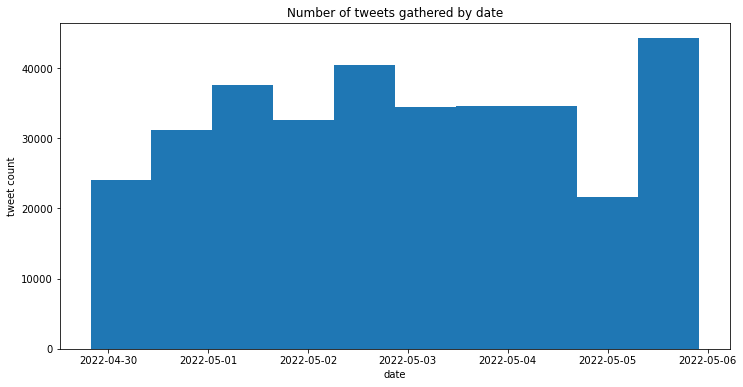

In [180]:
# look at the number of tweets gathered by date.
plt.figure(figsize = (12,6))
plt.title("Number of tweets gathered by date")
plt.hist(tudf['created_at'])
plt.xlabel("date")
plt.ylabel("tweet count")
plt.show()

There is a region of missed tweets in the data at the end of May 4 and into May 5, causing a drop in the count in that bin.

### conversation Id
The `conversation_id` is the id of the "base" tweet. If it's different from the tweet id, then the tweet is a reply somewhere in a thread with the base tweet as the root.

In [182]:
#look at the conversation ids. Most are the same.
tudf['conversation_id']

tweet_id
1521733018293084160    1521733018293084160
1521733015738662913    1521733015738662913
1521733011414257664    1521733011414257664
1521733010504445954    1521733010504445954
1521733001981444096    1521731925559418880
                              ...         
1521994904523706368    1521994904523706368
1521994898974588929    1521994898974588929
1521994886941413376    1521994886941413376
1521994883032039424    1521994883032039424
1521994876677672966    1521994876677672966
Name: conversation_id, Length: 335327, dtype: int64

In [183]:
# What tweets have the same conversation id as index (id)?
is_reply = tudf['conversation_id'] != tudf.index
is_reply.sum()

31827

In [184]:
is_reply.sum()/len(tudf)

0.09491332341266882

About 9% of these tweets are in reply to another tweet.

---
###  reply_settings

Comes from `tweets`. A setting for who is allowed to reply. The great majority (99.6%!) are set to `everyone`. A few thousandths are reserved only for users following the tweeter, or for users mentioned in the tweet.

In [185]:
# look at reply_settings value counts.
rsvcs = tudf['reply_settings'].value_counts(normalize='yeah')*100
rsvcs

everyone          99.572060
following          0.241853
mentionedUsers     0.186087
Name: reply_settings, dtype: float64

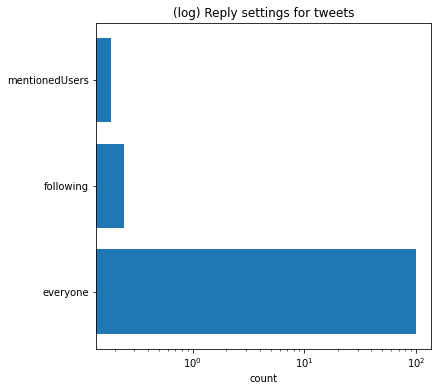

In [188]:
#visualize these value counts.
plt.figure(figsize = (6,6))
plt.barh(width=rsvcs, y=rsvcs.index, log = True)
plt.title("(log) Reply settings for tweets")
plt.xlabel('count');

---
### Language `lang`

A JSON converter for iso language codes to their proper english names was grabbed from [github/haliaeetus iso-639](https://github.com/haliaeetus/iso-639). This is used to look at all the tweet languages assigned by Twitter by converting a 2-character code into a readable name.

In [192]:
#import the language dictionary
with open('./iso_639-1.json', 'r', encoding='utf-8') as lang_file:
    lang_dict = json.load(lang_file)
lang_dict['und'] = {'name':'undefined'}
lang_dict['in'] = {'name':'Indonesian'} #filling in some missing ones
lang_dict['iw'] = {'name':'Hebrew'}

In [193]:
#look at an example entry
lang_dict['aa']

{'639-1': 'aa',
 '639-2': 'aar',
 'family': 'Afro-Asiatic',
 'name': 'Afar',
 'nativeName': 'Afaraf',
 'wikiUrl': 'https://en.wikipedia.org/wiki/Afar_language'}

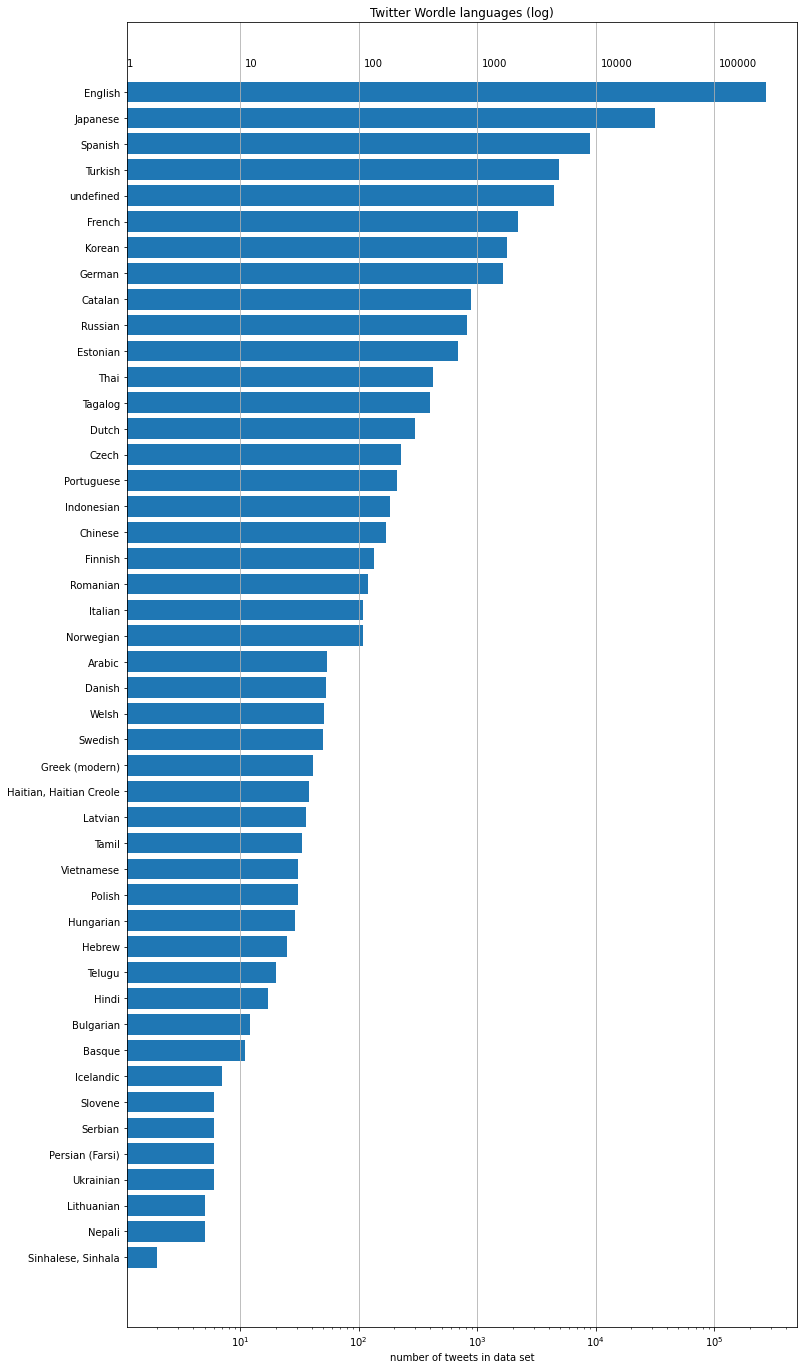

In [204]:
#plot all languages by frequency

def plot_tweet_languages(pandas_dataframe, log = True, figsize = (12,24), num_text = True, reverse = True):
    lang_vcs = pandas_dataframe['lang'].value_counts()
    if reverse:
        lang_vcs = lang_vcs[::-1]
    lang_vcs_names = [
        lang_dict[lang]['name']
        for lang in lang_vcs.index
    ]
    fig = plt.figure(figsize=figsize)
    plt.grid(axis = 'x')
    plt.barh(width=lang_vcs, y=lang_vcs_names, log = log)
    plt.title('Twitter Wordle languages' + (' (log)' if log else ''))
    plt.xlabel("number of tweets in data set")
    if num_text:
        for xpos in np.logspace(0,5,6):
            plt.text(x = xpos*1.1, y = 46, s= str(int(xpos)))
    plt.show()
    return None

plot_tweet_languages(tudf)

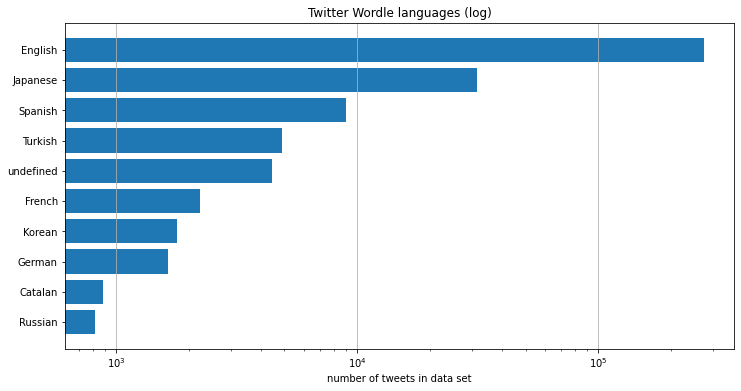

In [261]:
#plot just the top few.
top_langs_to_plot = ['en', 'es','ja', 'tr','und', 'fr', 
                    'ko', 'de','ca','ru']

plot_tweet_languages(tudf[tudf['lang'].apply(lambda lang: lang in top_langs_to_plot)], num_text=False, log = True, figsize = (12,6))

---
### entities_tweet

These were `entities` in the tweets data. Entities are json-like columns with the following keys:

In [206]:
entities_tweet_keys = ['urls', 'mentions', 'hashtags', 'annotations', 'cashtags']

In [207]:
#look at some entities.
tudf['entities_tweet'].head()

tweet_id
1521733018293084160    {'urls': [{'start': 54, 'end': 77, 'url': 'htt...
1521733015738662913    {'urls': [{'start': 58, 'end': 81, 'url': 'htt...
1521733011414257664                                                   {}
1521733010504445954                                                   {}
1521733001981444096    {'mentions': [{'start': 0, 'end': 12, 'usernam...
Name: entities_tweet, dtype: object

This JSON-like column needs to be split up. Define a function that will take these tags and create a new column in `tudf` for them.

In [262]:
#goes straight from json-looking-but-with-single-quotes strings to a list of dicts using ast.literal_eval()
def series_literal_eval(pandas_series):
    new_series = list(map(lambda some_string: ast.literal_eval(some_string), list(pandas_series)))
    return new_series


# takes in a pandas DataFrame, a list of JSON-like columns, expands the columns into their own
# DataFrame with the set of all keys as columns, properly assigns the original tweet index,
# and joins the results onto the original.
def expand_json_cols(pandas_dataframe, json_cols, inplace = False, drop_json_cols = False):
    #save the original index. confirmed it creates a new object, not a link to the last one
    original_index = pandas_dataframe.index
    #make a new dataframe to return if not altering the original
    if not inplace:
        new_df = pandas_dataframe.copy()
    # perform the merges over all the json_cols
    for column in json_cols:
        #create a new DataFrame from the column's jsons.
        new_json_df = pd.json_normalize(series_literal_eval(pandas_dataframe[column]))
        #assign the same indices as the original df to prepare for join
        new_json_df.index = pandas_dataframe.index
        #rename columns with a prefix so they are tracable and don't overwrite
        new_json_df = new_json_df.add_prefix(column)
        #join the expanded json columns to the original data
        if inplace:
            pandas_dataframe = pd.merge(pandas_dataframe, new_json_df, how = 'left')
            if drop_json_cols:
                pandas_dataframe.drop(columns = column, inplace = True)
        else:
            new_df = new_df.join(new_json_df)
            if drop_json_cols:
                new_df.drop(columns = column, inplace = True)
    #when that's done, return the result
    if inplace:
        #already altered the original dataframe
        return None
    else:
        return new_df

In [266]:
# turn the entities_tweet column into a series of columns, one for each of the possible keys.
tudf = expand_json_cols(tudf, ['entities_tweet'], drop_json_cols=True)

### entities_tweeturls
The first key in `entities_tweet`. Values in `entities_tweeturls` appear to have a base set of keys, with start and end some integers that appear to typically be 23 characters long. This is the same length as the url string, which appears to be a twitter-specific "bit.ly" or "tiny url" style url. These also come with expanded_url and display_url which have the original url with or without the https:// prefix.

The start and end keys appear to be common amongst all of these entities. They give the location in the tweet text of the entity.

There are other keys: `media_key` is a string of format number_numbernumbernumber

In [267]:
tudf['entities_tweeturls'].head()

tweet_id
1521733018293084160    [{'start': 54, 'end': 77, 'url': 'https://t.co...
1521733015738662913    [{'start': 58, 'end': 81, 'url': 'https://t.co...
1521733011414257664                                                  NaN
1521733010504445954                                                  NaN
1521733001981444096                                                  NaN
Name: entities_tweeturls, dtype: object

In [268]:
# list frequency of number of linked urls (nonzero)
entities_tweeturls_vcs = tudf['entities_tweeturls'].apply(lambda x: len(x) if type(x) == list else x).value_counts()
entities_tweeturls_vcs

1.0    80761
2.0     1318
3.0      106
4.0       22
6.0        3
5.0        1
Name: entities_tweeturls, dtype: int64

In [269]:
#look at some url entries.
expanded_tweet_urls = [
    entry
    for entry in tudf['entities_tweeturls'].dropna()
]
expanded_tweet_urls[:5]

[[{'start': 54,
   'end': 77,
   'url': 'https://t.co/oJCukg4JnD',
   'expanded_url': 'https://wordle.danielfrg.com/',
   'display_url': 'wordle.danielfrg.com',
   'images': [{'url': 'https://pbs.twimg.com/news_img/1521670739459411968/tTDycHOP?format=jpg&name=orig',
     'width': 1200,
     'height': 630},
    {'url': 'https://pbs.twimg.com/news_img/1521670739459411968/tTDycHOP?format=jpg&name=150x150',
     'width': 150,
     'height': 150}],
   'status': 200,
   'title': 'Un juego de palabras diario',
   'description': 'Adivina la palabra oculta en 6 intentos. Un nuevo puzzle cada día.',
   'unwound_url': 'https://wordle.danielfrg.com/'}],
 [{'start': 58,
   'end': 81,
   'url': 'https://t.co/ifnVQsE6bO',
   'expanded_url': 'https://wordle.danielfrg.com/ciencia/index.html',
   'display_url': 'wordle.danielfrg.com/ciencia/index.…',
   'images': [{'url': 'https://pbs.twimg.com/news_img/1521711979752136704/Qr2DllcV?format=jpg&name=orig',
     'width': 1200,
     'height': 630},
    {'ur

In [270]:
# how many are there?
len(expanded_tweet_urls)

82211

### entities_tweetmentions

A list of users mentioned in the tweet. Includes the username and user id.

Each entry is a list of dicts. Each dict is itself a user.

In [271]:
# look at some expanded_tweet_mentions
expanded_tweet_mentions = [
    entry
    for entry in tudf['entities_tweetmentions'].dropna()
]
expanded_tweet_mentions[:10]

[[{'start': 0, 'end': 12, 'username': 'RwellsWells', 'id': '331622540'}],
 [{'start': 0,
   'end': 16,
   'username': 'misfortunateApe',
   'id': '1275838631891152898'},
  {'start': 17,
   'end': 31,
   'username': 'SamuelAlpha77',
   'id': '1353120743199023106'},
  {'start': 32, 'end': 40, 'username': '1kisfud', 'id': '1495802955580297216'},
  {'start': 41,
   'end': 53,
   'username': 'SumPersonal',
   'id': '1437848652085669894'},
  {'start': 54,
   'end': 69,
   'username': 'ifyouknowyk4ir',
   'id': '1105516614978596864'},
  {'start': 70,
   'end': 84,
   'username': '42Chainlink42',
   'id': '1350970179128356866'},
  {'start': 85,
   'end': 101,
   'username': 'onlyshitpost777',
   'id': '1150564524354764800'}],
 [{'start': 0, 'end': 9, 'username': 'albolt76', 'id': '1160130818678972416'},
  {'start': 10,
   'end': 24,
   'username': 'aBitSquirrely',
   'id': '1248231058614747137'},
  {'start': 25, 'end': 34, 'username': 'dawardle', 'id': '1165789231'}],
 [{'start': 8,
   'end': 

In [272]:
# how many of these mentioned users are themselves tweeters in the list?

def get_mentioned_users(entities_mentioned_list, unique = False):
    extracted_mentions = []
    for this_entities_mentioned in entities_mentioned_list:
        for mentioned_user in this_entities_mentioned:
            extracted_mentions.append([mentioned_user['username'], mentioned_user['id']])
    if unique:
        return list(map(lambda extracted_mention: list(np.unique(extracted_mention)), extracted_mentions))
    return extracted_mentions

unique_mentioned_users = get_mentioned_users(expanded_tweet_mentions, unique=True)
len(unique_mentioned_users)

37300

In [273]:
#look at some unique mentioned users.
unique_mentioned_users[:10]

[['331622540', 'RwellsWells'],
 ['1275838631891152898', 'misfortunateApe'],
 ['1353120743199023106', 'SamuelAlpha77'],
 ['1495802955580297216', '1kisfud'],
 ['1437848652085669894', 'SumPersonal'],
 ['1105516614978596864', 'ifyouknowyk4ir'],
 ['1350970179128356866', '42Chainlink42'],
 ['1150564524354764800', 'onlyshitpost777'],
 ['1160130818678972416', 'albolt76'],
 ['1248231058614747137', 'aBitSquirrely']]

In [274]:
#check how many users are the original post users.
mentioned_users_in_users_unique = [  
    int(mentioned_user[0]) in users.index
    for mentioned_user in unique_mentioned_users
    if mentioned_user[0].isnumeric()
]

np.mean(mentioned_users_in_users_unique)

0.5409774436090226

About 55% of mentioned users themselves are original posters. This is blind to replies, where mentions are automatically added to a tweet. The point is that about half of these mentioned users aren't even posting completed Wordles themselves! Mentions may be a good way to spread the game via word-of-mouth, but one would need to track if these users eventually post themselves. Remember: a person posting their Wordle game is not I.F.F. they played Wordle --- many of these people could be avid players.

In [275]:
#do the same for a list of non-unique mentions. Includes the user for every mention in the set, including repeats.
#for some reason, unique = True/False also switches the order of the username and id
all_mentioned_users = get_mentioned_users(entities_mentioned_list=expanded_tweet_mentions, unique= False)
mentioned_user_in_users = [  
    int(mentioned_user[1]) in users.index
    for mentioned_user in all_mentioned_users
    if mentioned_user[1].isnumeric()
]

np.mean(mentioned_user_in_users)

0.5412868632707775

This is almost the same fraction, but a tiny bit larger. Most mentions are unique.

### entities_tweethashtags

Looking at the hashtags that come with a tweet.

In [276]:
#look at some hashtag entries.
tudf['entities_tweethashtags'].dropna()

tweet_id
1521732994817740800      [{'start': 67, 'end': 78, 'tag': 'ポケモンWordle'}]
1521732956125122561        [{'start': 0, 'end': 10, 'tag': 'WordleCAT'}]
1521732947589873664      [{'start': 87, 'end': 98, 'tag': 'ポケモンWordle'}]
1521732873975386113    [{'start': 0, 'end': 7, 'tag': 'Wordle'}, {'st...
1521732844640518144            [{'start': 0, 'end': 7, 'tag': 'Wordle'}]
                                             ...                        
1521995229712183296       [{'start': 47, 'end': 57, 'tag': 'Wordle320'}]
1521995088444162048      [{'start': 80, 'end': 91, 'tag': 'ポケモンWordle'}]
1521995045569708036            [{'start': 0, 'end': 7, 'tag': 'Wordle'}]
1521994920067747845            [{'start': 0, 'end': 7, 'tag': 'AlWird'}]
1521994909661958146     [{'start': 167, 'end': 177, 'tag': 'Wordle320'}]
Name: entities_tweethashtags, Length: 31604, dtype: object

In [277]:
#What percentage of tweets have hashtags?
len(tudf['entities_tweethashtags'].dropna())/len(tudf)

0.09424830091224387

About 9% of the tweets have at least one hashtag.

In [278]:
# get all hashtags in a single dataframe.
def get_all_hashtags(list_of_hashtag_lists, hashtag_key='tag', flat = True):
    if flat:
        complete_hashtag_list = []
        for hashtag_list in list_of_hashtag_lists:
            for hashtag_dict in hashtag_list:
                complete_hashtag_list.append(hashtag_dict[hashtag_key])
    else:
        complete_hashtag_list = [
            [
                hashtag_dict[hashtag_key]
                for hashtag_dict in hashtag_list
            ]
            for hashtag_list in list_of_hashtag_lists
        ]
    return complete_hashtag_list

all_hashtags_df = pd.DataFrame(get_all_hashtags(tudf['entities_tweethashtags'].dropna(), flat = True), columns = ["hashtag"])

In [279]:
# list of hashtags by frequency
all_hashtags_df['hashtag'].value_counts()[:50]

ポケモンWordle            13081
Wordle                 6011
wordle                 2327
WordleCAT              1965
dailywordleclub         960
вордли                  812
Wordle318               743
Wordle316               698
Wordle317               670
Wordle320               605
Heardle                 525
dailywordchallenge      500
Wordle315               455
Wordle319               425
워들                      371
한글                      369
Korean                  367
mywordle                356
wordleTR                349
Worldle                 320
AlWird                  279
galego                  262
WordleGalego            258
wordle316               199
DailyWordleClub         185
wordle318               183
WordleEnglish           182
WordleEN                175
wordle317               174
wordle320               174
Wordle5                 167
wordle7                 166
wordle6                 165
WordleEUS               126
hadejSlova              116
Thwordle            

In [280]:
#export unique wordle hashtags for assigning game
all_hashtags_df.to_csv('./EDA/all_hashtags.csv')

The top result is `ポケモンWordle`, specifically a Pokemon Wordle clone popular in Japan.

Following are simply `Wordle` and `wordle`.

Fourth is `WordleCAT`, for Catalan.

Next, and further ahead, is `Wordle`XXX, a hashtag specifically for that day's Wordle, with XXX the number.

In [281]:
#get distributions of number of hashtags per tweet.
hashtag_num_distribution = pd.DataFrame(tudf['entities_tweethashtags'].apply(lambda x: len(x) if type(x) == list else 0))

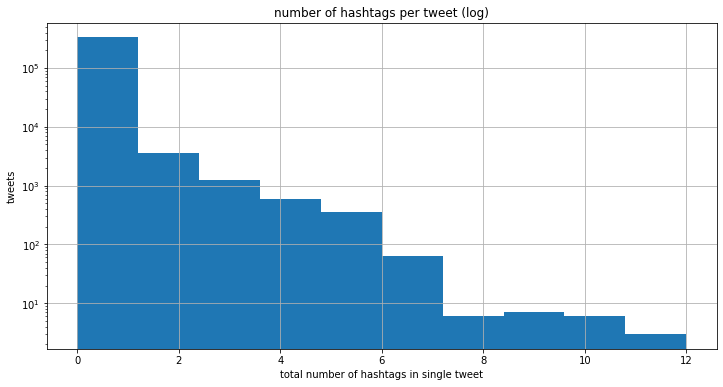

In [283]:
#plot hashtag count distribution.
hashtag_num_distribution['entities_tweethashtags'].hist(log = True, figsize = (12,6))
plt.xlabel("total number of hashtags in single tweet")
plt.ylabel("tweets")
plt.title("number of hashtags per tweet (log)");

In [284]:
# create a column of just the hashtags for each tweet. Don't bother to ast.literal_eval, just search
# for hashtags using regex.

#define regex searcher for tags
regex = r"'tag': '(.*?)'"

#save the hashtags
tudf['hashtags'] = hashtags = tudf['entities_tweethashtags'].apply(lambda entry: re.findall(regex, str(entry)) if type(entry) == list else [])

In [285]:
# create a new bool column for simply if a tweet has hashtags or not.
tudf['has_hashtags'] = tudf['hashtags'].apply(lambda hashtag_list: len(hashtag_list) > 0)

In [286]:
# What fraction of tweets have hashtags?
tudf['has_hashtags'].mean()

0.09424830091224387

This fraction is the same found before. This confirms we got all the tweets with hashtags marked in the list.

It appears that a small number of hashtags may be useful for assigning the game. All we really care about at this point is the text of the hashtag itself.

The hashtag `Wordle` appears in games that aren't "legit" Wordles from the NYTimes. These should be checked. `WordleXXX` is a hashtag that corresponds to a legitimate Wordle, but these also appear in the text.

### entities_tweetsannotations

Twitter has a bunch of ids for topics and assigns probabilities that a tweet is about a certain topic.
It's cool that you can look up tweets by topic id. I guess that's how a lot of people stay on top of things for their own projects about a single topic.

[The docs](https://developer.twitter.com/en/docs/twitter-api/annotations/overview) have an overview of the kinds of entities things can be.

In [287]:
#look at some of the annotations
tudf['entities_tweetannotations'].dropna()

tweet_id
1521727434374418432    [{'start': 12, 'end': 18, 'probability': 0.707...
1521726764883619840    [{'start': 19, 'end': 27, 'probability': 0.318...
1521726119682228228    [{'start': 20, 'end': 26, 'probability': 0.474...
1521725413877293056    [{'start': 15, 'end': 31, 'probability': 0.366...
1521723789180088320    [{'start': 51, 'end': 54, 'probability': 0.593...
                                             ...                        
1521996804979671045    [{'start': 0, 'end': 5, 'probability': 0.3086,...
1521996157475762176    [{'start': 140, 'end': 149, 'probability': 0.8...
1521995907297861633    [{'start': 0, 'end': 23, 'probability': 0.5194...
1521995400865107968    [{'start': 0, 'end': 5, 'probability': 0.4368,...
1521994909661958146    [{'start': 13, 'end': 19, 'probability': 0.361...
Name: entities_tweetannotations, Length: 2538, dtype: object

In [288]:
tudf['entities_tweetannotations'].dropna().iloc[0]

[{'start': 12,
  'end': 18,
  'probability': 0.7079,
  'type': 'Product',
  'normalized_text': 'twitter'}]

In [289]:
tudf['entities_tweetannotations'].dropna().iloc[1]

[{'start': 19,
  'end': 27,
  'probability': 0.318,
  'type': 'Other',
  'normalized_text': 'Star Wars'}]

### entities_tweetscashtags

A very small number of tweets (only one!) has a "cashtag." These were added as a way to keep track of stock prices.

In [290]:
tudf.loc[tudf['entities_tweetcashtags'].dropna().index]

,conversation_id,reply_settings,lang,possibly_sensitive,source,public_metrics_tweet,text,context_annotations,author_id,created_at,referenced_tweets,in_reply_to_user_id,attachments,geo,withheld_tweet,name,public_metrics_user,url,description,profile_image_url,location,protected,username,verified,entities_user,pinned_tweet_id,withheld_user,entities_tweeturls,entities_tweetmentions,entities_tweethashtags,entities_tweetannotations,entities_tweetcashtags,hashtags,has_hashtags
tweet_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1521363122812030976,1521363122812030976,everyone,en,False,Twitter for iPhone,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Wordle 318 5/6\r\n\r\n⬛⬛🟩⬛⬛\r\n⬛🟨🟩⬛⬛\r\n🟨🟩🟩⬛⬛\...,"[{'domain': {'id': '30', 'name': 'Entities [En...",1447577070465429510,2022-05-03 05:36:48+00:00,[],0.0,{},{},{},0,0,0,0,0,0,0,0,0,0,0.0,0,NaN,NaN,NaN,NaN,"[{'start': 69, 'end': 71, 'tag': 'h'}]",[],False


### possibly_sensitive

Less than 1% of the tweets are marked as possibly_sensitive.

In [291]:
#get percentage of possibly_sensitive tweets
tudf['possibly_sensitive'].value_counts(normalize='yeah')

False    0.991191
True     0.008809
Name: possibly_sensitive, dtype: float64

In [292]:
# What do possibly sensitive tweets look like?
tudf[tudf['possibly_sensitive']].head()

,conversation_id,reply_settings,lang,possibly_sensitive,source,public_metrics_tweet,text,context_annotations,author_id,created_at,referenced_tweets,in_reply_to_user_id,attachments,geo,withheld_tweet,name,public_metrics_user,url,description,profile_image_url,location,protected,username,verified,entities_user,pinned_tweet_id,withheld_user,entities_tweeturls,entities_tweetmentions,entities_tweethashtags,entities_tweetannotations,entities_tweetcashtags,hashtags,has_hashtags
tweet_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1521732020044546050,1521732020044546050,everyone,und,True,Twitter for iPhone,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",#WordleCAT 124 3/6\n\n🟩🟨⬜⬜🟩\n🟩🟩🟩⬜🟩\n🟩🟩🟩🟩🟩\n\nh...,[],2465123766,2022-05-04 06:02:40+00:00,[],0.0,{},{},{},Maria Font,"{'followers_count': 11, 'following_count': 52,...",,,https://pbs.twimg.com/profile_images/141650585...,,False,Mafontp,False,{},1.279520e+18,{},"[{'start': 39, 'end': 62, 'url': 'https://t.co...",NaN,"[{'start': 0, 'end': 10, 'tag': 'WordleCAT'}]",NaN,NaN,[WordleCAT],True
1521731907632852992,1521731907632852992,everyone,ja,True,Twitter for iPhone,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",ポケモンWordle 5/10\n\n⬛⬛⬛⬛🟩\n⬛⬛⬛⬛🟩\n⬛🟩⬛⬛🟩\n⬛🟩⬛⬛🟩\...,"[{'domain': {'id': '45', 'name': 'Brand Vertic...",1184725640076914691,2022-05-04 06:02:13+00:00,[],0.0,{},{},{},0,0,0,0,0,0,0,0,0,0,0.000000e+00,0,"[{'start': 48, 'end': 71, 'url': 'https://t.co...",NaN,"[{'start': 73, 'end': 84, 'tag': 'ポケモンWordle'}]",NaN,NaN,[ポケモンWordle],True
1521731773092225024,1521731773092225024,everyone,und,True,Twitter for iPhone,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",#WordleCAT 124 5/6\n\n⬜⬜⬜⬜🟩\n⬜🟩⬜⬜🟩\n⬜🟩🟩⬜🟩\n🟩🟩🟩...,[],1180367820,2022-05-04 06:01:41+00:00,[],0.0,{},{},{},Toni,"{'followers_count': 83, 'following_count': 392...",,Lletissó d’adopció,https://pbs.twimg.com/profile_images/144575407...,,False,ToniRouge77,False,{},1.387744e+18,{},"[{'start': 51, 'end': 74, 'url': 'https://t.co...",NaN,"[{'start': 0, 'end': 10, 'tag': 'WordleCAT'}]",NaN,NaN,[WordleCAT],True
1521731038292099075,1521731038292099075,everyone,en,True,Twitter for iPhone,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Wordle (ES) #118 5/6\n\n⬜🟨⬜🟨🟨\n🟩🟩⬜🟨⬜\n🟩🟩⬜⬜🟩\n...,"[{'domain': {'id': '30', 'name': 'Entities [En...",452862948,2022-05-04 05:58:46+00:00,[],0.0,{},{},{},Alejandra López ❤️💛❤️,"{'followers_count': 412, 'following_count': 36...",,Shippeadora Turquil oficial!!,https://pbs.twimg.com/profile_images/139140381...,Turquía,False,alejitasi,False,{},1.478831e+18,{},"[{'start': 54, 'end': 77, 'url': 'https://t.co...",NaN,NaN,NaN,NaN,[],False
1521730686197157889,1521730686197157889,everyone,es,True,Twitter for Android,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Wordle Científico #52 3/6\n\n⬜🟩⬜⬜⬜\n🟨🟨🟨🟨⬜\n🟩🟩🟩...,"[{'domain': {'id': '30', 'name': 'Entities [En...",1057296265195732992,2022-05-04 05:57:22+00:00,[],0.0,{},{},{},Andoni Zalla,"{'followers_count': 235, 'following_count': 11...",,,https://pbs.twimg.com/profile_images/141920373...,,False,joseba_zorrilla,False,{},0.000000e+00,{},"[{'start': 46, 'end': 69, 'url': 'https://t.co...",NaN,NaN,NaN,NaN,[],False


In [293]:
#what languages are sensitive tweets?
tudf[tudf['possibly_sensitive']]['lang'].value_counts()

en     1370
ja      974
es      215
tr      146
und      60
fr       58
de       41
ko       37
ru       16
ca       13
cs        7
et        4
zh        4
th        2
fi        1
no        1
tl        1
pt        1
da        1
hu        1
nl        1
Name: lang, dtype: int64

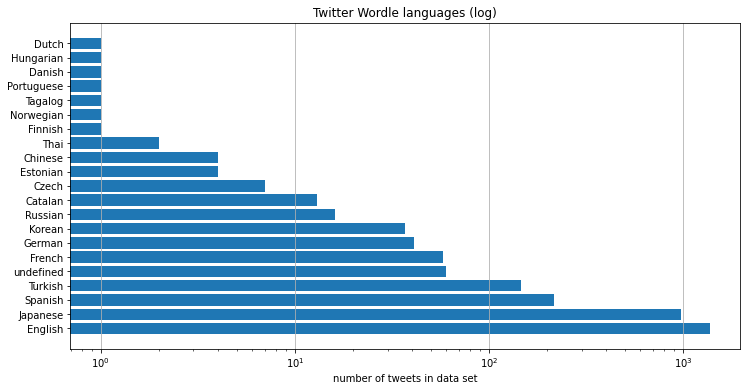

In [297]:
#language distribution of possibly_sensitive tweets
plot_tweet_languages(tudf[tudf['possibly_sensitive']], figsize = (12,6), num_text=False, reverse = False)


### Source

Source appears to be the name of the program that sent in the tweet. There are over 350 unique ones, with most of these applied to single tweets. The heavy hitters are unsurprising popular programs.

|          software           |    fraction |
|:--------------------|-----------:|
| Twitter for iPhone  | 0.466511   |
| Twitter for Android | 0.340715   |
| Twitter Web App     | 0.137656   |
| Twitter for iPad    | 0.0271263  |
| TweetDeck           | 0.00942429 |
| Tweetbot for iΟS    | 0.00509013 |

In [298]:
#look at value counts
tudf['source'].value_counts()[:6]

Twitter for iPhone     156426
Twitter for Android    113244
Twitter Web App         47042
Twitter for iPad         9046
TweetDeck                3185
Tweetbot for iΟS         1730
Name: source, dtype: int64

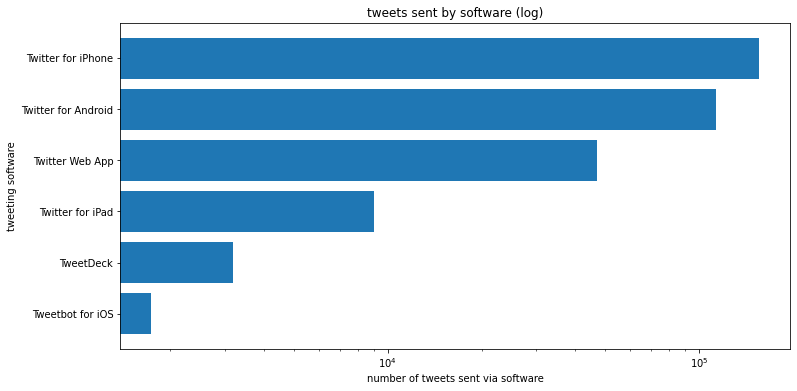

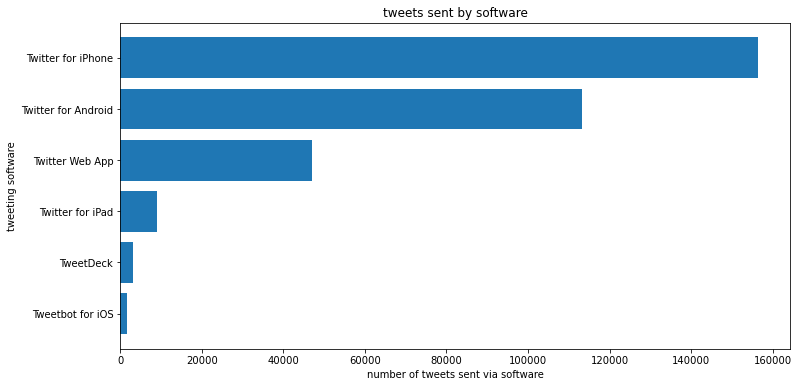

In [300]:
#plot them, both with log and linear scales.
top_source_vcs = tudf['source'].value_counts()[:6][::-1]

plt.figure(figsize = (12,6))
plt.barh(width = top_source_vcs, y=top_source_vcs.index, log = True)
plt.xlabel('number of tweets sent via software')
plt.ylabel("tweeting software")
plt.title("tweets sent by software (log)");
plt.show()


plt.figure(figsize = (12,6))
plt.barh(width = top_source_vcs, y=top_source_vcs.index, log = False)
plt.xlabel('number of tweets sent via software')
plt.ylabel("tweeting software")
plt.title("tweets sent by software");
plt.show()

### public_metrics_tweet

These consist of:
- retweet_count
- reply_count
- like_count
- quote_count

In [301]:
tudf['public_metrics_tweet'].iloc[0]

"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}"

In [302]:
#turn the public_metrics_tweet column into a series of columns.
# turn the entities_tweet column into a series of columns, one for each of the possible keys.
tudf = expand_json_cols(tudf, ['public_metrics_tweet'], drop_json_cols=True)

In [303]:
tudf[tudf.columns[-4:]].head()

,public_metrics_tweetretweet_count,public_metrics_tweetreply_count,public_metrics_tweetlike_count,public_metrics_tweetquote_count
tweet_id,,,,
1521733018293084160,0,0,0,0
1521733015738662913,0,0,0,0
1521733011414257664,0,0,0,0
1521733010504445954,0,0,0,0
1521733001981444096,0,0,0,0


### public_metrics_tweetretweet_count

The vast majority are not retweeted.

There are a few that were tweeted a huge number of times! 

In [304]:
tudf['public_metrics_tweetretweet_count'].value_counts()

0       330575
1         3600
2          354
3          121
4           71
41          68
10          52
140         49
58          47
5           38
35          37
8           36
34          32
6           30
25          24
20          20
21          19
23          16
138         16
139         14
12          13
11          11
7            8
16           7
15           6
18           5
30           5
72           3
71           3
134          3
70           3
2742         3
9            3
74           2
14           2
48           2
1713         2
558          2
131          2
345          2
135          2
19           1
40           1
367          1
263          1
129          1
239          1
8587         1
6921         1
31           1
32           1
184          1
559          1
24           1
343          1
961          1
121          1
69           1
1499         1
8588         1
Name: public_metrics_tweetretweet_count, dtype: int64

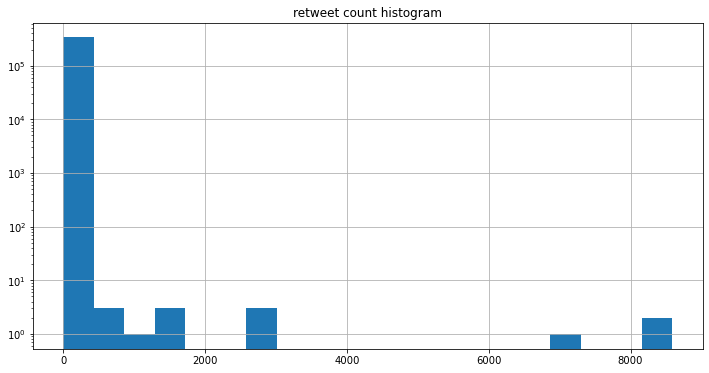

In [305]:
tudf['public_metrics_tweetretweet_count'].hist(bins = 20, log = True, figsize = (12,6))
plt.title("retweet count histogram");

In [306]:
#look at these tweets that were retweeted many times.
tudf[tudf['public_metrics_tweetretweet_count'] > 500]

,conversation_id,reply_settings,lang,possibly_sensitive,source,text,context_annotations,author_id,created_at,referenced_tweets,in_reply_to_user_id,attachments,geo,withheld_tweet,name,public_metrics_user,url,description,profile_image_url,location,protected,username,verified,entities_user,pinned_tweet_id,withheld_user,entities_tweeturls,entities_tweetmentions,entities_tweethashtags,entities_tweetannotations,entities_tweetcashtags,hashtags,has_hashtags,public_metrics_tweetretweet_count,public_metrics_tweetreply_count,public_metrics_tweetlike_count,public_metrics_tweetquote_count
tweet_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1521523004508975104,1521523004508975104,everyone,en,False,Twitter for iPhone,RT @cametek: Wordle 235\n\n⬛⬛⬛⬛⬛\n⬛⬛⬛⬛⬛\n⬛⬛🟪⬛⬛...,"[{'domain': {'id': '30', 'name': 'Entities [En...",1501400213025550345,2022-05-03 16:12:07+00:00,"[{'type': 'retweeted', 'id': '1491263558923210...",0.0,{},{},{},0,0,0,0,0,0,0,0,0,0,0.000000e+00,0,NaN,"[{'start': 3, 'end': 11, 'username': 'cametek'...",NaN,NaN,NaN,[],False,1713,0,0,0
1521496553231425539,1521496553231425539,everyone,en,False,Twitter for Android,RT @GeorgeNootFound: Wordle 229 X/6\n\n🟨🟨⬛🟨🟨\n...,"[{'domain': {'id': '30', 'name': 'Entities [En...",825691456895455232,2022-05-03 14:27:00+00:00,"[{'type': 'retweeted', 'id': '1489268441374597...",0.0,{},{},{},Leigh⁷🇵🇭,"{'followers_count': 501, 'following_count': 12...",,🏳‍🌈early gang gigglechamp | gimme lore crumbs pls,https://pbs.twimg.com/profile_images/150650238...,Republic of the Philippines,False,thejintoyurjoon,False,{},0.000000e+00,{},NaN,"[{'start': 3, 'end': 19, 'username': 'GeorgeNo...",NaN,NaN,NaN,[],False,2742,0,0,0
1521492943080759298,1521492943080759298,everyone,en,False,Twitter for Android,RT @VorosTwins: Today's Wordle is SUS\n\n⬛🟩🟩🟩 ...,"[{'domain': {'id': '30', 'name': 'Entities [En...",701785116,2022-05-03 14:12:40+00:00,"[{'type': 'retweeted', 'id': '1516797822238031...",0.0,{},{},{},Biscotte,"{'followers_count': 183, 'following_count': 69...",,"j'ai 21 ans, il/he, Je suis un Jojofag, j'ador...",https://pbs.twimg.com/profile_images/144676852...,,False,pierre590,False,"{'description': {'mentions': [{'start': 97, 'e...",1.477292e+18,{},NaN,"[{'start': 3, 'end': 14, 'username': 'VorosTwi...",NaN,"[{'start': 24, 'end': 29, 'probability': 0.379...",NaN,[],False,559,0,0,0
1521292805355843587,1521292805355843587,everyone,en,False,Twitter for iPad,RT @VorosTwins: Today's Wordle is SUS\r\n\r\n⬛...,"[{'domain': {'id': '30', 'name': 'Entities [En...",4473988098,2022-05-03 00:57:23+00:00,"[{'type': 'retweeted', 'id': '1516797822238031...",0.0,{},{},{},GOBBIFIED,"{'followers_count': 78, 'following_count': 198...",,"「Google LeShoes, at your service! (OUT OF ORDE...",https://pbs.twimg.com/profile_images/150529566...,,False,GlNGADENSETSU,False,{},1.492770e+18,{},NaN,"[{'start': 3, 'end': 14, 'username': 'VorosTwi...",NaN,"[{'start': 24, 'end': 29, 'probability': 0.379...",NaN,[],False,558,0,0,0
1521087200901103616,1521087200901103616,everyone,ko,False,Twitter Web App,RT @cehigi: #Wordle 중독증 3/6\r\n\r\n⬜⬜⬜⬜⬜\r\n⬜🟩...,"[{'domain': {'id': '30', 'name': 'Entities [En...",1432335794262343687,2022-05-02 11:20:23+00:00,"[{'type': 'retweeted', 'id': '1486992649982967...",0.0,{'media_keys': ['3_1486992170259476484']},{},{},0,0,0,0,0,0,0,0,0,0,0.000000e+00,0,"[{'start': 47, 'end': 70, 'url': 'https://t.co...","[{'start': 3, 'end': 10, 'username': 'cehigi',...","[{'start': 12, 'end': 19, 'tag': 'Wordle'}]",NaN,NaN,[Wordle],True,961,0,0,0
1520845001495879685,1520845001495879685,everyone,en,False,Twitter Web App,RT @VorosTwins: Today's Wordle is SUS\n\n⬛🟩🟩🟩 ...,"[{'domain': {'id': '30', 'name': 'Entities [En...",1062694393742802944,2022-05-01 19:17:58+00:00,"[{'type': 'retweeted', 'id': '1516797822238031...",0.0,{},{},{},DeniceBenice !!,"{'followers_count': 165, 'following_count': 33...",https://t.co/nOCiNnNfxS,I draw occasionally,https://pbs.twimg.com/profile_images/143430278...,(she/they),False,DeniceBenice,False,"{'url': {'urls': [

![500+ RT tweet: today's wordle is sus.](./EDA/pix/sustweet.png)

This one is a retweet of a popular tweet with an Among Us nintendo character in it. The game led to a rise in the use of the word "sus" as short for suspicious.

Perhaps retweet counts are inherited by retweets.

All of the tweets with >500 retweets are themselves retweets.

### public_metrics_tweettweet_replycount

Reply counts are similar.

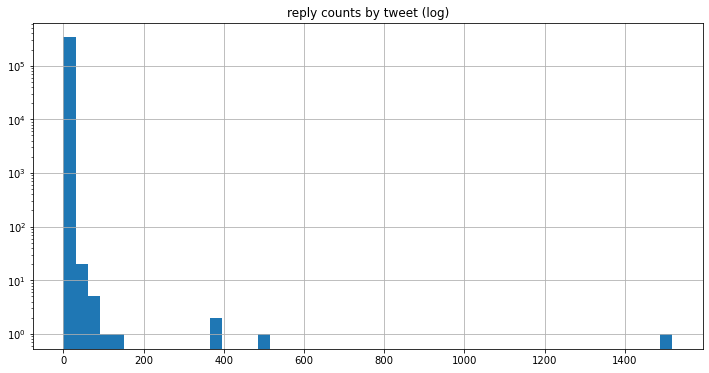

In [307]:
tudf['public_metrics_tweetreply_count'].hist(bins = 50,log = True, figsize = (12,6))
plt.title("reply counts by tweet (log)");

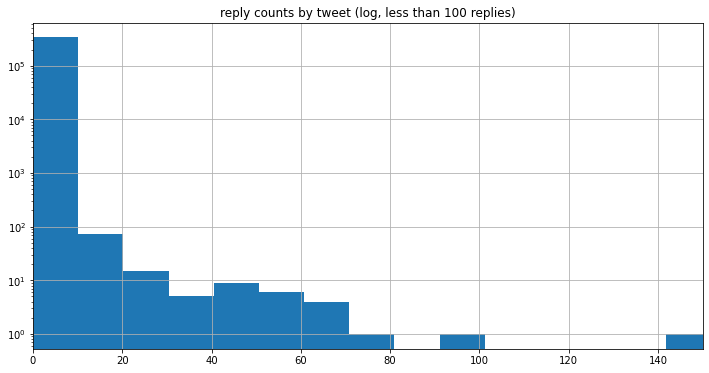

In [308]:
tudf['public_metrics_tweetreply_count'].hist(bins = 150,log = True, figsize = (12,6))
plt.title("reply counts by tweet (log, less than 100 replies)")
plt.xlim(0,150);

### public_metrics_tweetlike_count

Like counts distributions are similar to reply and retweet counts.

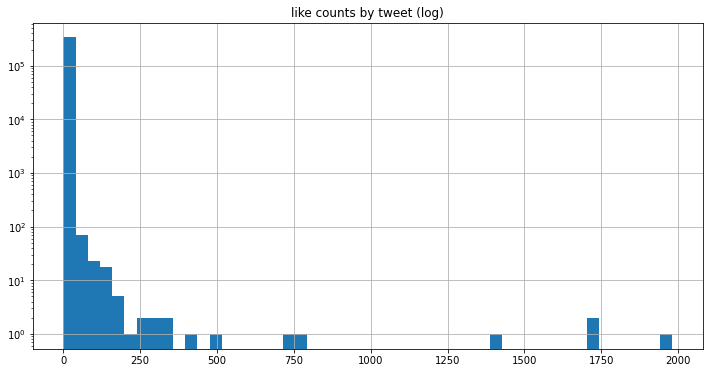

In [126]:
tudf['public_metrics_tweetlike_count'].hist(bins = 50,log = True, figsize = (12,6))
plt.title("like counts by tweet (log)");

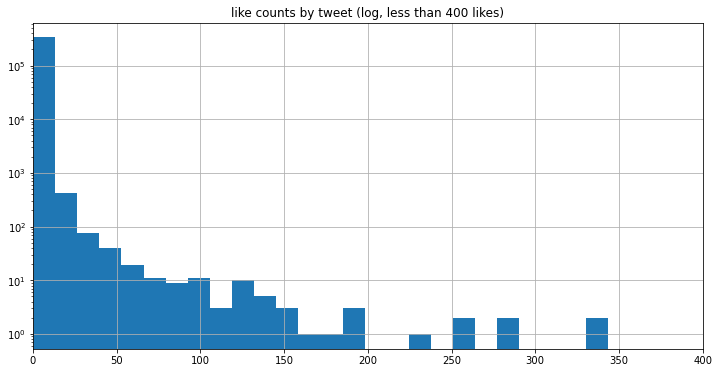

In [127]:
tudf['public_metrics_tweetlike_count'].hist(bins = 150,log = True, figsize = (12,6))
plt.title("like counts by tweet (log, less than 400 likes)")
plt.xlim(0,400);

In [128]:
#look at tweets with more than 250 likes
tudf[tudf['public_metrics_tweetlike_count'] > 250]

,conversation_id,reply_settings,lang,possibly_sensitive,source,text,context_annotations,author_id,created_at,referenced_tweets,in_reply_to_user_id,attachments,geo,withheld_tweet,name,public_metrics_user,url,description,profile_image_url,location,protected,username,verified,entities_user,pinned_tweet_id,withheld_user,entities_tweeturls,entities_tweetmentions,entities_tweethashtags,entities_tweetannotations,entities_tweetcashtags,public_metrics_tweetretweet_count,public_metrics_tweetreply_count,public_metrics_tweetlike_count,public_metrics_tweetquote_count
tweet_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1521446701801910272,1521446701801910272,everyone,en,False,Twitter for iPhone,Wordle 318 2/6*\r\n\r\n⬛🟩⬛⬛⬛\r\n🟩🟩🟩🟩🟩,"[{'domain': {'id': '30', 'name': 'Entities [En...",1294500310191349760,2022-05-03 11:08:55+00:00,[],0.0,{},{},{},hannie ross,"{'followers_count': 283709, 'following_count':...",https://t.co/2yDWVPTkOK,main: @hannahxxrose | #rosetwt | banner: @neex...,https://pbs.twimg.com/profile_images/148368167...,,False,hanniexxrose,False,"{'url': {'urls': [{'start': 0, 'end': 23, 'url...",1.510697e+18,{},NaN,NaN,NaN,NaN,NaN,10,26,1722,0
1520833608272867328,1520833608272867328,everyone,en,False,Twitter Web App,Today was a tough one #Wordle315 \nWordle 316 ...,"[{'domain': {'id': '10', 'name': 'Person', 'de...",17953972,2022-05-01 18:32:42+00:00,[],0.0,{},{},{},bert kreischer,"{'followers_count': 881888, 'following_count':...",https://t.co/KYSpUUG31B,"I am a Party Animal, Comedian, Actor, Author, ...",https://pbs.twimg.com/profile_images/119139535...,Los Angeles,False,bertkreischer,True,"{'url': {'urls': [{'start': 0, 'end': 23, 'url...",1.520475e+18,{},NaN,NaN,"[{'start': 22, 'end': 32, 'tag': 'Wordle315'}]",NaN,NaN,4,68,411,0
1520805744710356992,1520805744710356992,everyone,en,False,Twitter for iPhone,I’m giving a hint because the Wordle Master is...,"[{'domain': {'id': '10', 'name': 'Person', 'de...",27491578,2022-05-01 16:41:59+00:00,[],0.0,{},{},{},Nancy Lee Grahn,"{'followers_count': 170985, 'following_count':...",https://t.co/APsFdvSgme,I act on TV and as a citizen. The opinions her...,https://pbs.twimg.com/profile_images/105601465...,A blue state,False,NancyLeeGrahn,True,"{'url': {'urls': [{'start': 0, 'end': 23, 'url...",1.498707e+18,{},NaN,NaN,NaN,"[{'start': 30, 'end': 42, 'probability': 0.408...",NaN,4,69,256,2
1520713571054850048,1520713571054850048,everyone,en,False,Twitter for Android,Wow\nWordle 316 6/6\n\n⬛⬛⬛⬛🟨\n⬛🟩🟩⬛⬛\n🟩🟩🟩⬛⬛\n🟩🟩...,"[{'domain': {'id': '30', 'name': 'Entities [En...",381091977,2022-05-01 10:35:43+00:00,[],0.0,{'media_keys': ['3_1520713567443501057']},{},{},Arno/daily wordle😜/boots/music,"{'followers_count': 537, 'following_count': 28...",,"He/him. Musician. Be the best you can be, alw...",https://pbs.twimg.com/profile_images/151070535...,,False,arnojones1,False,{},0.000000e+00,{},"[{'start': 56, 'end': 79, 'url': 'https://t.co...",NaN,NaN,NaN,NaN,23,6,286,0
1520644473142788097,1520644473142788097,everyone,en,False,Twitter for Android,Is it cheating to use a dictionary? \nWordle 3...,"[{'domain': {'id': '10', 'name': 'Person', 'de...",454071012,2022-05-01 06:01:09+00:00,[],0.0,{},{},{},Jill Wine-Banks,"{'followers_count': 573498, 'following_count':...",https://t.co/1bXqjHUIoa,MSNBC legal analyst. Author #TheWatergateGirl....,https://pbs.twimg.com/profile_images/146686684...,"Chicago, IL",False,JillWineBanks,True,"{'url': {'urls': [{'start': 0, 'end': 23, 'url...",1.368981e+18,{},NaN,NaN,NaN,NaN,NaN,21,373,715,13
1520305212245827586,1520305212245827586,everyone,en,False,Twitter for Android,Tricky tonight\nWordle 315 4/6\n\n🟨⬜⬜⬜⬜\n⬜🟨🟨⬜⬜...,"[{'domain': {'id': '10', 'name': 'Person', 'de...",454071012,2022-04-30 07:33:03+00:00,[],0.0,{},{},{},Jill Wine-Banks,"{'followers_count': 573498, 'following_count':...",https://t.co/1bXqjHUIoa,MSNBC legal analyst. Author #TheWatergateGirl....,https://pbs.twimg.com/profile_images/146686684...,"Chicago, IL",False,JillWineBanks,True,"{'url': {'urls': [{'start': 0, 'end'

### public_metrics_tweetquote_count

Quoting is not a popular feature.

In [129]:
#number of quotes by fraction
tudf['public_metrics_tweetquote_count'].value_counts('nromalize')

0     0.996490
1     0.003415
2     0.000054
3     0.000012
5     0.000006
8     0.000006
15    0.000006
6     0.000003
4     0.000003
7     0.000003
13    0.000003
Name: public_metrics_tweetquote_count, dtype: float64

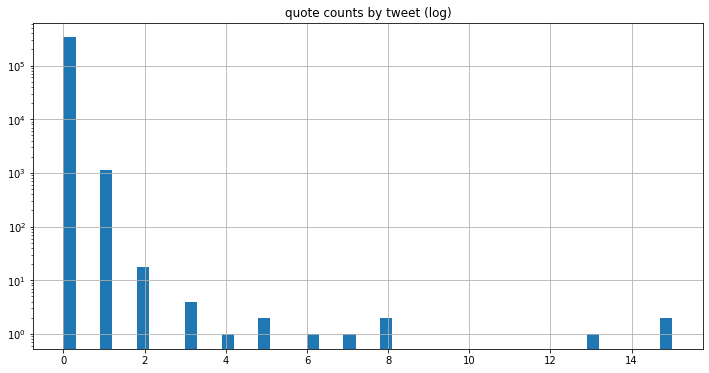

In [130]:
# plot quote number histogram
tudf['public_metrics_tweetquote_count'].hist(bins = 50,log = True, figsize = (12,6))
plt.title("quote counts by tweet (log)");

In [131]:
#look at tweets with quotes.
tudf[tudf['public_metrics_tweetquote_count'] > 0]

,conversation_id,reply_settings,lang,possibly_sensitive,source,text,context_annotations,author_id,created_at,referenced_tweets,in_reply_to_user_id,attachments,geo,withheld_tweet,name,public_metrics_user,url,description,profile_image_url,location,protected,username,verified,entities_user,pinned_tweet_id,withheld_user,entities_tweeturls,entities_tweetmentions,entities_tweethashtags,entities_tweetannotations,entities_tweetcashtags,public_metrics_tweetretweet_count,public_metrics_tweetreply_count,public_metrics_tweetlike_count,public_metrics_tweetquote_count
tweet_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1521725904065548289,1521725904065548289,everyone,en,False,Twitter for iPhone,Wordle 319 3/6\r\n\r\n⬜⬜🟩⬜⬜\r\n🟩🟩🟩🟩⬜\r\n🟩🟩🟩🟩🟩\...,"[{'domain': {'id': '30', 'name': 'Entities [En...",571864971,2022-05-04 05:38:22+00:00,[],0.0,{},{},{},MarkFitz90,"{'followers_count': 942, 'following_count': 11...",,"Ex “Job”, NHS, & Charity worker. Enjoys 🚴 🏊‍♂️...",https://pbs.twimg.com/profile_images/136053711...,Chesterfield,False,Fitz90MARK,False,{},1.450819e+18,{},NaN,NaN,NaN,NaN,NaN,0,0,1,1
1521721108583563264,1521721108583563264,everyone,en,False,Twitter for iPhone,Wordle 319 3/6\r\n\r\n⬛🟩🟩🟨⬛\r\n⬛🟩🟩⬛🟩\r\n🟩🟩🟩🟩🟩\...,"[{'domain': {'id': '30', 'name': 'Entities [En...",38226081,2022-05-04 05:19:19+00:00,[],0.0,{},{},{},Meridith Nordin,"{'followers_count': 441, 'following_count': 45...",,"My interests are diverse...Sports,travel, musi...",https://pbs.twimg.com/profile_images/109194618...,"ÜT: 44.684937,-93.282909",False,Meridith19,False,{},0.000000e+00,{},NaN,NaN,NaN,NaN,NaN,0,0,1,1
1521718751011426305,1521718751011426305,everyone,en,False,Twitter Web App,Wordle 319 5/6\r\n\r\n🟨⬜⬜🟩⬜\r\n⬜🟨⬜🟩⬜\r\n⬜⬜🟩🟩🟨\...,"[{'domain': {'id': '30', 'name': 'Entities [En...",715654161493139456,2022-05-04 05:09:57+00:00,[],0.0,{'media_keys': ['3_1521718742677438464']},{},{},Ailey 🍒,"{'followers_count': 564, 'following_count': 76...",https://t.co/MOstQZkzMe,your local milkman ☆ art: @shuppeii ☆ private:...,https://pbs.twimg.com/profile_images/152046973...,she/they 🏳️‍⚧️ 19,False,Aikilime,False,"{'url': {'urls': [{'start': 0, 'end': 23, 'url...",1.488746e+18,{},"[{'start': 58, 'end': 81, 'url': 'https://t.co...",NaN,NaN,NaN,NaN,0,2,0,1
1521711300791136256,1521711300791136256,everyone,ko,False,Twitter for Android,워들 206 X/6\r\nhttps://t.co/Q3eJpB5HPo\r\n\r\n거...,[],1451073432,2022-05-04 04:40:20+00:00,[],0.0,{},{},{},루아(Rua),"{'followers_count': 4323, 'following_count': 3...",,🇰🇷KOR Cosplayer | RUA | Team.CSL | 👋변계체블\r\n🚫D...,https://pbs.twimg.com/profile_images/151161630...,Weibo: RUA_cos / Insta: ru_a09,False,Ru_a09,False,{},1.519938e+18,{},"[{'start': 11, 'end': 34, 'url': 'https://t.co...",NaN,NaN,NaN,NaN,2,1,1,1
1521702550189363202,1521702550189363202,everyone,en,False,Twitter for Android,Wordle (ES) #117 6/6\r\n\r\n🟨⬜⬜⬜🟩\r\n⬜🟨⬜⬜🟩\r\...,"[{'domain': {'id': '30', 'name': 'Entities [En...",1371573064044060680,2022-05-04 04:05:34+00:00,[],0.0,{},{},{},0,0,0,0,0,0,0,0,0,0,0.000000e+00,0,"[{'start': 60, 'end': 83, 'url': 'https://t.co...",NaN,NaN,NaN,NaN,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1521996614612701184,1521996614612701184,everyone,en,False,Twitter for Android,Wordle 320 3/6\n\n⬜🟨⬜🟨🟨\n🟩⬜🟩🟩⬜\n🟩🟩🟩🟩🟩,"[{'domain': {'id': '30', 'name': 'Entities [En...",2561782624,2022-05-04 23:34:04+00:00,[],0.0,{},{},{},oluwadarasimi,"{'followers_count': 389, 'following_count': 50...",,FC Barcelona. Pep. Federer. Osaka. \nWe are ti...,https://pbs.twimg.com/profile_images/152018457...,"Orimattila, Suomi",False,TheOdejobi,False,{},8.558066e+17,{},NaN,NaN,NaN,NaN,NaN,0,0,0,1
1521995762787254272,1521995762787254272,everyone,en,True,Twitter for iPhone,Wordle 319 3/6\n\n🟨⬜⬜🟩⬜\n⬜🟨🟩🟩🟨\n🟩🟩🟩🟩🟩 https://...,"[{'domain': {'id': '30', 'name': 'Entities [En...",1228018114555592704,2022-05-04 23:30:41+00:00,[],0.0,{'media_keys': ['3_1521995758341267458']},{},{},Zaddy Zick,"{'followers_count':

# Text

This is the text of the tweet! There are all sorts of things we could do with this. Tweets were specifically found using the search term `🟩 Wordle`, looking for any tweet with `Wordle` and `🟩`.

In [311]:
tudf['text'].head(40)

tweet_id
1521733018293084160    Wordle (ES)  #118 5/6\n\n⬜⬜🟨🟩⬜\n⬜⬜🟨🟩⬜\n⬜⬜⬜🟩🟩\n...
1521733015738662913    Wordle Científico #52 5/6\n\n⬜⬜⬜⬜🟨\n🟨⬜⬜⬜🟩\n⬜🟩⬜...
1521733011414257664         Wordle 319 4/6\n\n🟨🟨⬜⬜⬜\n🟨⬜⬜🟩⬜\n🟩🟨⬜🟩🟨\n🟩🟩🟩🟩🟩
1521733010504445954    Back in the saddle.\n\nWordle 319 3/6\n\n⬜🟩⬜🟨⬜...
1521733001981444096    @RwellsWells Same. Are we both spotters? Haha ...
1521733001264222208                Wordle 319 3/6\n\n🟨🟨⬜🟩⬜\n⬜⬜🟩🟩🟨\n🟩🟩🟩🟩🟩
1521732998068060163    Wordle Científico #52 5/6\n\n🟨⬜⬜⬜⬜\n🟨🟨⬜⬜🟩\n⬜⬜🟨...
1521732994817740800    ポケモンWordle 4/10\n\n⬛🟨⬛⬛⬛\n⬛⬛🟨⬛🟨\n⬛⬛🟨⬛🟨\n🟩🟩🟩🟩🟩\...
1521732989977305088    @misfortunateApe @SamuelAlpha77 @1kisfud @SumP...
1521732984256315392    😒\n\nWordle 319 5/6\n\n⬜🟩🟩🟨⬜\n⬜⬜⬜🟩⬜\n🟩🟩🟩🟩⬜\n🟩🟩...
1521732983211888642    Wordle (ES)  #118 5/6\n\n⬜⬜⬜🟨🟨\n🟨🟨⬜⬜🟨\n⬜🟨🟨⬜🟩\n...
1521732974110298112    Wordle (ES)  #118 4/6\n\n⬜⬜🟨⬜🟩\n🟨⬜⬜⬜🟩\n⬜⬜⬜🟩🟩\n...
1521732967764140032    เวิร์ดเดล 98 4/6\n\n🟩⬜🟨🟨⬜\n🟩🟨⬜🟩⬜\n🟩⬜⬜⬜⬜\n🟩🟩🟩🟩🟩...
1521732956125122561    #WordleCAT 124 5/6\

Many of these are Spanish language, Pokemon, or some other non-English variant of the game. They must be removed. There are likely lots of other Wordle alternatives that aren't easily traced by `lang`.

In [314]:
#save the word pokemon
pokemon_string = 'ポケモン'

#make a new column to keep track of pokemon games
poke_list = tudf['text'].apply(lambda text: pokemon_string in text)
tudf['is_poke'] = poke_list

In [315]:
# look at a couple of the pokemon wordles
tudf[tudf['is_poke']].head(2)

,conversation_id,reply_settings,lang,possibly_sensitive,source,text,context_annotations,author_id,created_at,referenced_tweets,in_reply_to_user_id,attachments,geo,withheld_tweet,name,public_metrics_user,url,description,profile_image_url,location,protected,username,verified,entities_user,pinned_tweet_id,withheld_user,entities_tweeturls,entities_tweetmentions,entities_tweethashtags,entities_tweetannotations,entities_tweetcashtags,hashtags,has_hashtags,public_metrics_tweetretweet_count,public_metrics_tweetreply_count,public_metrics_tweetlike_count,public_metrics_tweetquote_count,is_poke
tweet_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1521732994817740800,1521732994817740800,everyone,ja,False,Twitter for Android,ポケモンWordle 4/10\n\n⬛🟨⬛⬛⬛\n⬛⬛🟨⬛🟨\n⬛⬛🟨⬛🟨\n🟩🟩🟩🟩🟩\...,"[{'domain': {'id': '45', 'name': 'Brand Vertic...",3290026848,2022-05-04 06:06:33+00:00,[],0.0,{},{},{},パピコ,"{'followers_count': 54, 'following_count': 377...",,好きなものがいろいろあります。\nアラフィフ,https://pbs.twimg.com/profile_images/117214859...,,False,yykco,False,{},0.000000e+00,{},"[{'start': 42, 'end': 65, 'url': 'https://t.co...",NaN,"[{'start': 67, 'end': 78, 'tag': 'ポケモンWordle'}]",NaN,NaN,[ポケモンWordle],True,0,0,0,0,True
1521732947589873664,1521732947589873664,everyone,ja,False,Twitter for iPhone,ポケモンWordle 7/10\n\n⬛🟨⬛⬛⬛ ⬛🟨⬛🟩⬛\n⬛⬛⬛⬛🟨 🟩🟩🟩🟩🟩\...,"[{'domain': {'id': '45', 'name': 'Brand Vertic...",4899257058,2022-05-04 06:06:21+00:00,[],0.0,{},{},{},ニャル田,"{'followers_count': 49, 'following_count': 53,...",https://t.co/0mHZ8ljx7u,TRPG→CoC/SW2.0/サタスペ/マギロギにも手出し中。 北水は公孫勝信者の林冲モンペ...,https://pbs.twimg.com/profile_images/125609227...,梁山泊という名のルルイエ,False,ryuyou_iaia,False,"{'url': {'urls': [{'start': 0, 'end': 23, 'url...",1.447864e+18,{},"[{'start': 62, 'end': 85, 'url': 'https://t.co...",NaN,"[{'start': 87, 'end': 98, 'tag': 'ポケモンWordle'}]",NaN,NaN,[ポケモンWordle],True,0,0,0,0,True


Others are Wordle (ES) in Spanish, Wordle CAT for Catalan.

In [316]:
tudf[tudf['lang'] == 'es'].head(3)

,conversation_id,reply_settings,lang,possibly_sensitive,source,text,context_annotations,author_id,created_at,referenced_tweets,in_reply_to_user_id,attachments,geo,withheld_tweet,name,public_metrics_user,url,description,profile_image_url,location,protected,username,verified,entities_user,pinned_tweet_id,withheld_user,entities_tweeturls,entities_tweetmentions,entities_tweethashtags,entities_tweetannotations,entities_tweetcashtags,hashtags,has_hashtags,public_metrics_tweetretweet_count,public_metrics_tweetreply_count,public_metrics_tweetlike_count,public_metrics_tweetquote_count,is_poke
tweet_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1521733015738662913,1521733015738662913,everyone,es,False,Twitter for Android,Wordle Científico #52 5/6\n\n⬜⬜⬜⬜🟨\n🟨⬜⬜⬜🟩\n⬜🟩⬜...,"[{'domain': {'id': '30', 'name': 'Entities [En...",360002014,2022-05-04 06:06:38+00:00,[],0.0,{},{},{},Ana V Garcia,"{'followers_count': 41, 'following_count': 136...",https://t.co/uMfikCmd0I,,https://pbs.twimg.com/profile_images/122215871...,Alcalá de Henares,False,AnaVGarciaG,False,"{'url': {'urls': [{'start': 0, 'end': 23, 'url...",0.0,{},"[{'start': 58, 'end': 81, 'url': 'https://t.co...",NaN,NaN,NaN,NaN,[],False,0,0,0,0,False
1521732998068060163,1521732998068060163,everyone,es,False,Twitter for Android,Wordle Científico #52 5/6\n\n🟨⬜⬜⬜⬜\n🟨🟨⬜⬜🟩\n⬜⬜🟨...,"[{'domain': {'id': '30', 'name': 'Entities [En...",1103932752,2022-05-04 06:06:33+00:00,[],0.0,{},{},{},Sonia Siles Porras,"{'followers_count': 69, 'following_count': 181...",,,https://pbs.twimg.com/profile_images/798534134...,Villanueva de Algaidas,False,silesporras,False,{},0.0,{},"[{'start': 58, 'end': 81, 'url': 'https://t.co...",NaN,NaN,NaN,NaN,[],False,0,0,0,0,False
1521732677891670021,1521732677891670021,everyone,es,False,Twitter for Android,Buenos días 🙃. Wordle (ES) #118 5/6\n\n⬜🟨🟨⬜⬜\...,"[{'domain': {'id': '30', 'name': 'Entities [En...",346211011,2022-05-04 06:05:17+00:00,[],0.0,{},{},{},BeitaBeuki,"{'followers_count': 102, 'following_count': 32...",,Recorriendo mi camino :),https://pbs.twimg.com/profile_images/864484056...,España,False,BeitaBeuki,False,{},0.0,{},"[{'start': 69, 'end': 92, 'url': 'https://t.co...",NaN,NaN,NaN,NaN,[],False,0,0,0,0,False


In [317]:
tudf[tudf['lang'] == 'ca'].head(3)

,conversation_id,reply_settings,lang,possibly_sensitive,source,text,context_annotations,author_id,created_at,referenced_tweets,in_reply_to_user_id,attachments,geo,withheld_tweet,name,public_metrics_user,url,description,profile_image_url,location,protected,username,verified,entities_user,pinned_tweet_id,withheld_user,entities_tweeturls,entities_tweetmentions,entities_tweethashtags,entities_tweetannotations,entities_tweetcashtags,hashtags,has_hashtags,public_metrics_tweetretweet_count,public_metrics_tweetreply_count,public_metrics_tweetlike_count,public_metrics_tweetquote_count,is_poke
tweet_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1521732956125122561,1521732956125122561,everyone,ca,False,Twitter for iPhone,#WordleCAT 124 5/6\n\n⬜🟨🟩⬜⬜\n⬜⬜🟩🟨⬜\n⬜🟩🟩⬜🟩\n⬜🟩🟩...,[],237254076,2022-05-04 06:06:23+00:00,[],0.000000e+00,{},{},{},Xavier Julian,"{'followers_count': 62, 'following_count': 135...",,,https://pbs.twimg.com/profile_images/142812138...,"iPhone: 41.482820,2.089419",False,xavjulian,False,{},0.0,{},"[{'start': 51, 'end': 74, 'url': 'https://t.co...",NaN,"[{'start': 0, 'end': 10, 'tag': 'WordleCAT'}]",NaN,NaN,[WordleCAT],True,0,0,0,0,False
1521731027294736385,1521713455283245057,everyone,ca,False,Twitter for iPhone,@RondaAbad Xiiiiiiiica! No t’ha acompanyat????...,[],11195372,2022-05-04 05:58:43+00:00,"[{'type': 'replied_to', 'id': '152171345528324...",1.343863e+18,{},{},{},Sergi Ferrús Peris,"{'followers_count': 963, 'following_count': 51...",https://t.co/cIIjfzjCOj,"Profe de secundària... i, eventualment, Alcald...",https://pbs.twimg.com/profile_images/119760355...,Pedreguer,False,sergiferrus,False,"{'url': {'urls': [{'start': 0, 'end': 23, 'url...",0.0,{},"[{'start': 88, 'end': 111, 'url': 'https://t.c...","[{'start': 0, 'end': 10, 'username': 'RondaAba...","[{'start': 49, 'end': 59, 'tag': 'WordleCAT'}]",NaN,NaN,[WordleCAT],True,0,0,0,0,False
1521729778537140224,1521729778537140224,everyone,ca,False,Twitter for Android,Que la força us acompanyi! #WordleCAT 124 6/6...,[],2973627621,2022-05-04 05:53:46+00:00,[],0.000000e+00,{},{},{},Pau Estanyol i Mola,"{'followers_count': 61, 'following_count': 260...",,El cor a l'Empordanet i la vida a Girona,https://pbs.twimg.com/profile_images/689475790...,,False,bestiari_urba,False,{},0.0,{},"[{'start': 85, 'end': 108, 'url': 'https://t.c...",NaN,"[{'start': 28, 'end': 38, 'tag': 'WordleCAT'}]",NaN,NaN,[WordleCAT],True,0,0,1,0,False


I don't want to throw out games of English Wordle if someone is writing in Spanish otherwise in the tweet, for example, and Twitter assigns it 'es'. The inverse of this also happens with many Chinese language players in other countries, playing NYTimes Wordle:

In [320]:
tudf[tudf['lang'] == 'zh'].head()

,conversation_id,reply_settings,lang,possibly_sensitive,source,text,context_annotations,author_id,created_at,referenced_tweets,in_reply_to_user_id,attachments,geo,withheld_tweet,name,public_metrics_user,url,description,profile_image_url,location,protected,username,verified,entities_user,pinned_tweet_id,withheld_user,entities_tweeturls,entities_tweetmentions,entities_tweethashtags,entities_tweetannotations,entities_tweetcashtags,hashtags,has_hashtags,public_metrics_tweetretweet_count,public_metrics_tweetreply_count,public_metrics_tweetlike_count,public_metrics_tweetquote_count,is_poke
tweet_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1521716152224919553,1521716152224919553,everyone,zh,True,Plurk,【劇透下收】Wordle 319 2/6\n\n⬛⬛⬛⬛⬛\n🟩🟩🟩🟩🟩\n銀牙！ http...,"[{'domain': {'id': '30', 'name': 'Entities [En...",306332971,2022-05-04 04:59:37+00:00,[],0.000000e+00,{},{},{},中和千野,"{'followers_count': 27, 'following_count': 171...",https://t.co/MUwfcQ8BUa,香港人。文字で普段広東、中国、日本、英語もおｋ\n音ゲー全般、作曲～♪、クルマ（特に痛車）、...,https://pbs.twimg.com/profile_images/318911562...,稚内,False,NKW39,False,"{'url': {'urls': [{'start': 0, 'end': 23, 'url...",0.000000e+00,{},"[{'start': 38, 'end': 61, 'url': 'https://t.co...",NaN,NaN,NaN,NaN,[],False,0,0,0,0,False
1521699987960352768,1521699987960352768,everyone,zh,False,Twitter for iPhone,Wordle 319 4/6\n\n🟨⬛⬛⬛⬛\n🟩🟨⬛⬛⬛\n🟩🟩🟨⬛⬛\n🟩🟩🟩🟩🟩\n...,"[{'domain': {'id': '30', 'name': 'Entities [En...",1345647030102876161,2022-05-04 03:55:23+00:00,[],0.000000e+00,{},{},{},0,0,0,0,0,0,0,0,0,0,0.000000e+00,0,NaN,NaN,NaN,NaN,NaN,[],False,0,0,0,0,False
1521690869518446593,1521690869518446593,everyone,zh,False,Twitter Web App,Tâi-lô \n台灣閩南語羅馬字 (Taiwanese Southern Min)64 5...,[],1440382418796486663,2022-05-04 03:19:09+00:00,[],0.000000e+00,{},{},{},0,0,0,0,0,0,0,0,0,0,0.000000e+00,0,"[{'start': 90, 'end': 113, 'url': 'https://t.c...",NaN,NaN,NaN,NaN,[],False,0,0,0,0,False
1521681797150433280,1517204410706718720,everyone,zh,False,Twitter for iPhone,TXT Wordle 123 4/6\n\n笑死我猜麵包幹嘛 麵包中毒欸\n\n⬜🟩⬜⬜⬜\...,"[{'domain': {'id': '10', 'name': 'Person', 'de...",1307202580729065472,2022-05-04 02:43:06+00:00,"[{'type': 'replied_to', 'id': '152168179420610...",1.307203e+18,{},{},{},辣炒年糕ᙏ̤̫,"{'followers_count': 135, 'following_count': 23...",https://t.co/DuV09YPKVn,❦ ᴛxᴛ ꜱᴏᴏʙɪɴ ᴛᴀᴇʜʏᴜɴ ↝ ʟᴏvᴇʀ｜偶爾暴言⚡️,https://pbs.twimg.com/profile_images/150981566...,🐰+🐿=💖→,False,isoobu00,False,"{'url': {'urls': [{'start': 0, 'end': 23, 'url...",1.513907e+18,{},NaN,NaN,NaN,NaN,NaN,[],False,0,0,1,0,False
1521667442715492352,1521667442715492352,everyone,zh,False,Twitter for Mac,Wordle 319 4/6\n\n⬛🟨🟨⬛⬛\n⬛🟨🟩🟨🟨\n⬛🟨🟩🟩🟩\n🟩🟩🟩🟩🟩\n...,"[{'domain': {'id': '30', 'name': 'Entities [En...",826737986,2022-05-04 01:46:04+00:00,[],0.000000e+00,{},{},{},歐喔欸喔@台灣,"{'followers_count': 98, 'following_count': 365...",,寫自我介紹就是一個貼標籤的過程，好啦其實是我不會寫,https://pbs.twimg.com/profile_images/148327010...,台灣,False,Allegretic,False,{},1.455784e+18,{},NaN,NaN,NaN,NaN,NaN,[],False,0,0,0,0,False


Some of these games are English language Wordle, but the tweet language is Chinese.

I should be able to distinguish these. This could be done with links. Do legitimate Wordle tweets link to the NYtimes page, or does Twitter find an associated link to them? Look back to the tweet urls.


### expanded_tweet_urls

In [318]:
#get a list of urls from tweets
just_the_urls_list = [
    [
        this_dict['expanded_url']
        for this_dict in this_list
    ]
    for this_list in expanded_tweet_urls
]

just_the_urls = pd.DataFrame(just_the_urls_list)

In [322]:
# look at some of that list
just_the_urls[:10]

,0,1,2,3,4,5
0,https://wordle.danielfrg.com/,None,None,None,None,None
1,https://wordle.danielfrg.com/ciencia/index.html,None,None,None,None,None
2,https://wordle.danielfrg.com/ciencia/index.html,None,None,None,None,None
3,https://wordle.mega-yadoran.jp/,None,None,None,None,None
4,https://wordle.danielfrg.com/,None,None,None,None,None
5,https://wordle.danielfrg.com/,None,None,None,None,None
6,https://bit.ly/wordlethai,None,None,None,None,None
7,http://wordle.gelozp.com,None,None,None,None,None
8,https://wordle.mega-yadoran.jp/,None,None,None,None,None
9,https://wordle.danielfrg.com/,None,None,None,None,None


Some of the tweets have more than one url, up to 5. What's the distribution of these urls counts?

In [323]:
# get the numbers of tweets with each number of urls attached
filled_number = [len(tudf)]
for column_num in just_the_urls.columns:
    filled_number.append( (len(just_the_urls[column_num].dropna())))
    #need to subtract the number from all previous or else it counts the same tweet multiple times
    for j in range(column_num):
        filled_number[j] = filled_number[j] - filled_number[column_num]
filled_number

[251504, 80599, 1288, 102, 22, 4, 3]

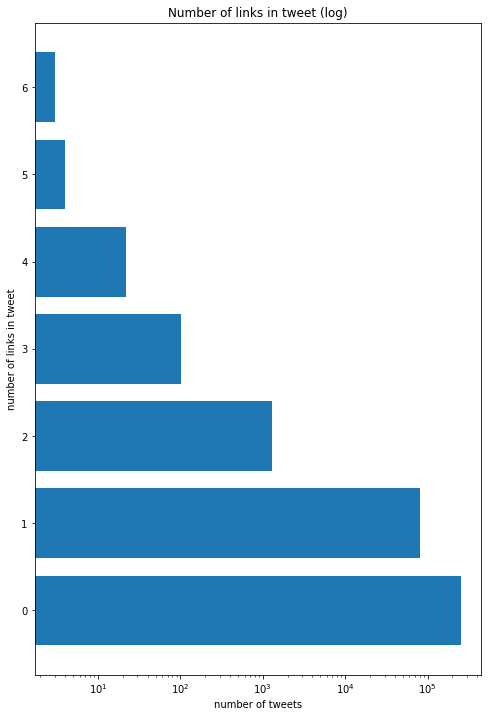

In [324]:
# plot these values.
plt.figure(figsize = (8,12))
plt.barh(width = filled_number, y = range(0,7), log = True)
plt.title('Number of links in tweet (log)')
plt.xlabel('number of tweets')
plt.ylabel('number of links in tweet');

In [325]:
# get all the urls in a flat list.
all_url_list = list(np.concatenate(just_the_urls_list))

In [327]:
#make that list a series so we can call value_counts easily.
all_url_list_series = pd.Series(all_url_list)
all_url_list_series.head()

0                      https://wordle.danielfrg.com/
1    https://wordle.danielfrg.com/ciencia/index.html
2    https://wordle.danielfrg.com/ciencia/index.html
3                    https://wordle.mega-yadoran.jp/
4                      https://wordle.danielfrg.com/
dtype: object

In [329]:
#record value counts of these urls
url_counts = all_url_list_series.value_counts()

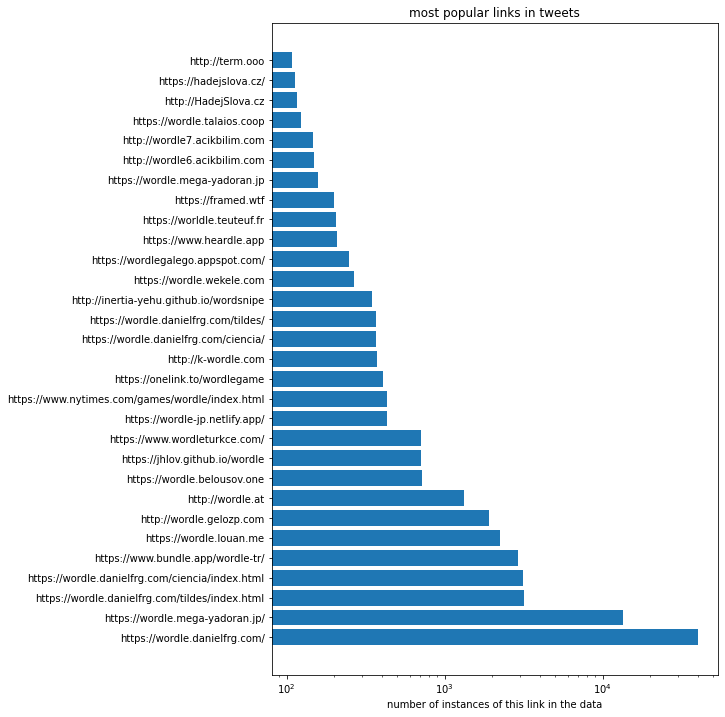

In [349]:
# plot the most popular urls.
number_urls_to_plot = 30

plt.figure(figsize = (8,12))
plt.title("most popular links in tweets")
plt.xlabel("number of instances of this link in the data")
plt.barh(width = url_counts[:number_urls_to_plot],
         y = url_counts[:number_urls_to_plot].index,
         log = True);

Most of these are foreign language alternatives. Some are different games based on the original (Pokemon, Heardle, Framed, Worldle).
- [wordle.danielfrg.com](wordle.danielfrg.com) is a Spanish language game
- [wordle.mega-yadoran.jp](https://wordle.mega-yadoran.jp/) is the Japanese language Pokemon Wordle
- [www.bundle.app/wordle-tr](http://www.bundle.app/wordle-tr) is Turkish
- [wordle.louan.me](https://wordle.louan.me) Le Mot - Wordle en français
- [wordle.gelozp.com](https://wordle.gelozp.com) Wordle CAT (Catalan)
- [wordle.at](http://wordle.at) is German (.at is for austria)
- [wordleturkce.com](http://www.wordleturkce.com/) is a(nother? or not?) Turkish variant.
- [https://jhlov.github.io/wordle/#/](https://jhlov.github.io/wordle/#/) Korean
- [belousov.one](https://wordle.belousov.one/) Russian
- [https://wordle-jp.netlify.app/](https://wordle-jp.netlify.app/) Japanese
- [nytimes.com](https://www.nytimes.com/games/wordle/index.html) The actual real New York Times Wordle page!
- [onelink.to](onelink.to/wordlegame) This is a link to [a google play app](https://play.google.com/store/apps/details?id=io.digitalsnacks.wordchallenge) that seems to be a wordle clone. Onelink appears to be a redirection service.
- The next two are danielfrg/Spanish language topic specified with tildes and science words.
- [k-wordle.com](k-wordle.com) Another Korean site
- [inertia-yehu.github.io/wordsnipe](inertia-yehu.github.io/wordsnipe)
- [Wordle Galego](https://wordlegalego.appspot.com/) Wordle Galego in Galician
- [Wordle Wekele](https://wordle.wekele.com/) Wordle in many languages
- [Worldle](https://worldle.teuteuf.fr/) "Worldle" Wordle variant based on country identification with shape and distance
- [Heardle](https://www.heardle.app) Heardle --- identifying a pop song based on the introduction
- [Framed](https://framed.wtf) Framed --- identifying a film based on screenshots

The presence of any one of these besides the nytimes link is probably a good identifier of the tweet NOT representing a legit Wordle game.

---

## Description

In [157]:
# how many user descriptions are filled?
tudf['user_has_description'] = tudf['description'] != 0
tudf['user_has_description'].value_counts('norm'), tudf['user_has_description'].value_counts()

(True     0.844055
 False    0.155945
 Name: user_has_description, dtype: float64,
 True     326191
 False     60266
 Name: user_has_description, dtype: int64)

77758 of the tweets are by users with descriptions. This is about 32% of the tweets.

# Missing user data

Unfortunately, lots of the gathered user data just doesn't seem to pair appropriately with the tweet data. There are user IDs (both in the index and the Unnamed: 0 column that were merged, before the "fix" was done) that appear in a saved `users_xx.csv` but not in the corresponding tweet data, and vice versa.

In [350]:
#get a list of user ids
user_id_list = list(users.index.astype(np.int64))

In [351]:
%%time
#how many "author_ids" are not in the user data?
user_id_list = list(users.index.astype(np.int64))
tudf['author_id'][::10].astype(np.int64).apply(lambda this_id: this_id in user_id_list).sum()

Wall time: 36 s


28358

In [352]:
len(tudf)

335327

In [353]:
28358/335327

0.08456819761009403

About 8% of the author_ids in the tweet data are not in the associated user data.

### created_at

We can find the rate of tweets from the dates.

In [356]:
# turn created_at string into a datetime
tudf['created_at'] = pd.to_datetime(tudf['created_at'])

In [357]:
#sort by created_at
tudf.sort_values(by = 'created_at', inplace= True)

In [358]:
# create a list of ones to easily perform inversion
tudf['ones'] = np.ones(len(tudf))

In [359]:
# latest and earliest tweet dates have already been grabbed
print(f'Tweets were gathered from\n{earliest} to\n{latest}, spanning\n{timespan}.')

Tweets were gathered from
2022-04-29 19:46:55+00:00 to
2022-05-05 21:59:57+00:00, spanning
6 days 02:13:02.


In [360]:
# create a column giving the timedelta since the previous tweet.
tudf.sort_values(by = 'created_at', inplace= True)
tudf['time_since_last_tweet'] = tudf['created_at'].diff()
# turn timedeltas into simple seconds.
tudf['time_since_last_tweet'] = tudf['time_since_last_tweet'].apply(lambda this_timedelta: this_timedelta.total_seconds())

# create a column 
tudf['wordle_tweet_rate'] = tudf['ones']/tudf['time_since_last_tweet']

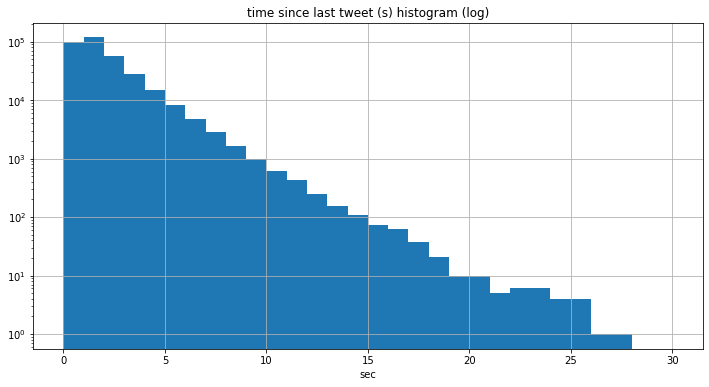

In [361]:
# plot time since last tweet
tudf[tudf['time_since_last_tweet'] < 30]['time_since_last_tweet'].hist(bins = range(31), log = True, figsize = (12,6))
plt.title( 'time since last tweet (s) histogram (log)' );
plt.xlabel('sec');

Text(0.5, 0, 'sec')

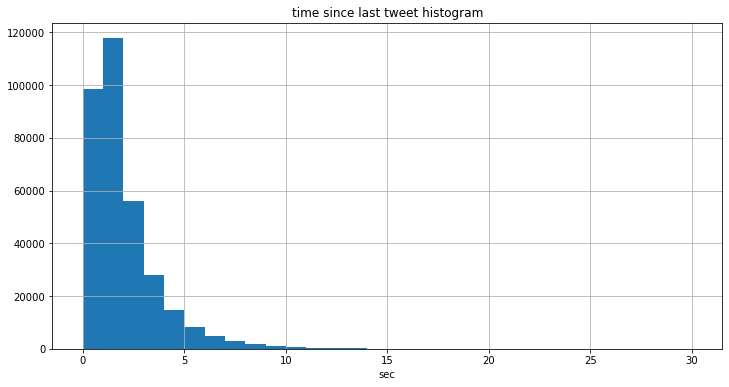

In [362]:
# the same, but linear axis.
tudf[tudf['time_since_last_tweet'] < 30]['time_since_last_tweet'].hist(bins = range(31), log = False, figsize = (12,6))
plt.title( 'time since last tweet histogram' );
plt.xlabel('sec')

In [367]:
plt.figure(figsize=(16,8))
plt.plot(tudf['created_at'], tudf['ones']/tudf['time_since_last_tweet_rolling_60'])
plt.title("Wordle tweet rate (from rolling average of 60)")
plt.xlabel("date (UTC)")
plt.ylabel("tweets/sec")


KeyError: 'time_since_last_tweet_rolling_60'

<Figure size 1152x576 with 0 Axes>

In [189]:
#make special times for certain parts of the country


edt_offset = 4 # 4 am utc == midnight east coast usa. gmt -4
pdt_offset = 6 #6 am == midnight west coast usa. gmt -6
tokyo_offset = 15 # 3pm UTC == midnight japan, korea. gmt +9
turkey_offset = 21  # 9pm UTC == midnight turkey, israel. gmt +3
france_offset = 22 #10 pm UTC = midnight france, germany. gmt +2
canberra_offset = 14 # 2 pm UTC == midnight ACT eastern australia. GMT + 10

#more appropriately, should make tzinfo the corresponding type. but.
def midnight_datetime_may2(offset, tzinfo = UTC):
    midnight = datetime(2022, 5, 2, 0 + offset, 0, 0 ,tzinfo = tzinfo)
    return midnight

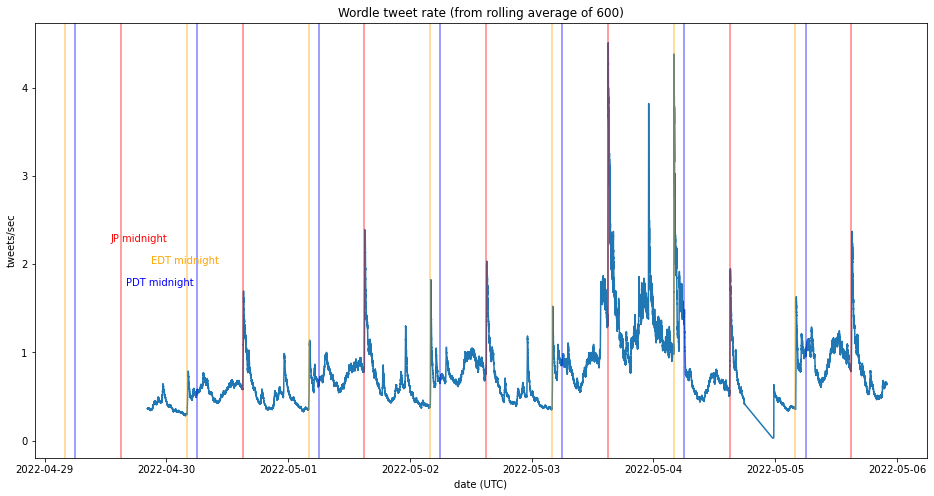

In [190]:
edt_text_position = datetime(2022, 4, 29, 21, 0, 0, tzinfo = UTC)
jp_text_position = datetime(2022, 4, 29, 13, 0, 0, tzinfo = UTC)
pdt_text_position = datetime(2022, 4, 29, 16, 0 ,0, tzinfo = UTC)

plt.figure(figsize=(16,8))
plt.plot(tudf['created_at'], tudf['ones']/tudf['time_since_last_tweet_rolling_600'])
plt.title("Wordle tweet rate (from rolling average of 600)")
plt.xlabel("date (UTC)")
plt.ylabel("tweets/sec")
plt.text(edt_text_position, 2, "EDT midnight", color = 'orange')
plt.text(jp_text_position, 2.25, "JP midnight", color = 'r')
plt.text(pdt_text_position, 1.75, "PDT midnight", color = 'b')
for day_offset in range(-2,5):
    plt.axvline(dt.timedelta(days=day_offset)+datetime(2022, 5, 1, 0 + pdt_offset, 0 , 0, tzinfo = UTC), color = colors.to_rgba('b', 0.5))
    plt.axvline(dt.timedelta(days=day_offset)+datetime(2022, 5, 1, 0 + tokyo_offset, 0 ,0 ,tzinfo = UTC), color = colors.to_rgba('r', 0.5))
    plt.axvline(dt.timedelta(days=day_offset)+datetime(2022, 5, 1, 0 + edt_offset, 0, 0 ,tzinfo = UTC), color = colors.to_rgba('orange',0.5))

In [191]:
tudf['tweet_rate_60'] = tudf['ones']/tudf['time_since_last_tweet_rolling_60']
tudf['tweet_rate_600'] = tudf['ones']/tudf['time_since_last_tweet_rolling_600']

In [192]:
# #do the same with rolling averages.
# plt.figure(figsize = (12,6))
# #make a line at UTC = 9pm, which is 6pm EDT.
# for fivepeeem in tudf[tudf['created_at'].apply(lambda x: x.hour == 21)]['created_at']:
#     plt.axvline(fivepeeem)
# #make a line at UTC = 4pm, which is noon EDT.
# for lunchtime in tudf[tudf['created_at'].apply(lambda x: x.hour == 16)]['created_at']:
#     plt.axvline(lunchtime, color = 'orange')    
# plt.plot(tudf['created_at'],tudf['time_since_last_tweet_mean60'])
# plt.ylim(0,5)
# plt.title("time since last tweet (rolling average --- 60 tweets)")
# plt.xlabel("date")
# plt.ylabel("average wait time (s)")

In [193]:
# #plot rolling averages in one day.
# plt.figure(figsize = (12,6))
# plt.xlim(datetime(2022, 5,2,0,0,0, tzinfo = UTC), datetime(2022, 5,3,0,0,0, tzinfo = UTC))
# plt.plot(tudf['created_at'],tudf['time_since_last_tweet_mean60'])
# plt.ylim(0,5)
# plt.title("time since last tweet (rolling average --- 60 tweets)")
# plt.xlabel("date")
# plt.ylabel("average wait time (s)")

In [194]:
# #plot the inverse. This is tweet frequency.

# UTC = tz.gettz('UTC')

# edt_offset = 4 # 4 am utc == midnight east coast usa. gmt -4
# pdt_offset = 6 #6 am == midnight west coast usa. gmt -6
# tokyo_offset = 15 # 3pm UTC == midnight japan, korea. gmt +9
# turkey_offset = 21  # 9pm UTC == midnight turkey, israel. gmt +3
# france_offset = 22 #10 pm UTC = midnight france, germany. gmt +2
# canberra_offset = 14 # 2 pm UTC == midnight ACT eastern australia. GMT + 10

# #more appropriately, should make tzinfo the corresponding type. but.
# def midnight_datetime_may2(offset, tzinfo = UTC):
#     midnight = datetime(2022, 5, 2, 0 + offset, 0, 0 ,tzinfo = tzinfo)
#     return midnight

# edt_midnight = midnight_datetime_may2(edt_offset)
# tokyo_midnight =  midnight_datetime_may2(tokyo_offset)
# turkey_midnight =  midnight_datetime_may2(turkey_offset)
# france_midnight = midnight_datetime_may2(france_offset)


# plt.figure(figsize = (12,6))
# plt.xlim(datetime(2022, 5,2,0,0,0, tzinfo = UTC), datetime(2022, 5,3,0,0,0, tzinfo = UTC))
# plt.plot(tudf['created_at'], tudf['ones']/tudf['time_since_last_tweet_mean60'])
# plt.ylim(0,3)
# plt.title("Wordle tweet frequency on May 2, 2022 (UTC) and midnights")
# plt.xlabel("date (UTC)")
# plt.ylabel("Frequency (hz)")

# plt.axvline(edt_midnight,  color = colors.to_rgba('orange',0.5))
# plt.axvline(tokyo_midnight, color = colors.to_rgba('orange',0.5))
# plt.axvline(turkey_midnight,  color = colors.to_rgba('orange',0.5))
# plt.axvline(france_midnight,  color = colors.to_rgba('orange',0.5))

# plt.text(edt_midnight, 2.5, "   EDT", color = 'orange')
# plt.text(tokyo_midnight, 2.5, "     Japan\n     Korea", color = 'orange')
# plt.text(turkey_midnight, 2.5, "     Turkey\n     Israel ", color = 'orange')
# plt.text(france_midnight, 2., "     France\n     Germany\n     Spain", color = 'orange')

In [195]:
#This is UTC, leading east coast USA by four hours. Some of these features definitely repeat.

# making the time series regular

### traces

The time data is irregular. Follow [this stack overflow](https://stackoverflow.com/questions/25234941/python-regularise-irregular-time-series-with-linear-interpolation) answer to use `traces` to make a regular time series.

> You can do this with traces. First, create a TimeSeries with your irregular measurements like you would a dictionary:
```python
    ts = traces.TimeSeries([
    (datetime(1992, 8, 27, 7, 46, 48), 28.0),
    (datetime(1992, 8, 27, 8, 0, 48), 28.2),
    ...
    (datetime(1992, 8, 27, 9, 3, 48), 30.0),
])
```

Then regularize using the sample method:

```python
    ts.sample(
    sampling_period=timedelta(minutes=15),
    start=datetime(1992, 8, 27, 8),
    end=datetime(1992, 8, 27, 9),
    interpolate='linear',
```
> This results in the following regularized version, where the gray dots are the original data and the orange is the regularized version with linear interpolation.

In [ ]:
# # Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install traces

[traces is pretty cool](https://traces.readthedocs.io/en/latest/#:~:text=The%20main%20object%20in%20traces,%3A45%3A56am%2C%20etc.&text=What%20if%20you%20want%20to,one%20of%20the%20measurement%20times.). It makes TimeSeries objects that interpolate between the data points by default. You can put any datetime in.

In [197]:
tudf['created_at']

1520127509051944961   2022-04-29 19:46:55+00:00
1520127524377972737   2022-04-29 19:46:59+00:00
1520127566845149185   2022-04-29 19:47:09+00:00
1520127576676704256   2022-04-29 19:47:11+00:00
1520127578593726464   2022-04-29 19:47:11+00:00
                                 ...           
1522335287988346882   2022-05-05 21:59:50+00:00
1522335296007847937   2022-05-05 21:59:52+00:00
1522335298574852103   2022-05-05 21:59:53+00:00
1522335308712497153   2022-05-05 21:59:55+00:00
1522335315381395456   2022-05-05 21:59:57+00:00
Name: created_at, Length: 386457, dtype: datetime64[ns, UTC]

In [196]:
# import traces

from datetime import datetime

from dateutil import tz

In [ ]:
# #make a time series of all tweets rate, rolling 600
# ts = traces.TimeSeries(
#         zip( tudf['created_at'],
#             tudf['ones']/tudf['time_since_last_tweet_rolling_600']
#         )
#     )

# tudf.iloc[0]['created_at']

In [ ]:
#Give the time series tz awareness when making values.

# UTC = tz.gettz('UTC')
# ts[datetime(2042, 2, 1,  6,  0,  0, tzinfo = UTC)]

In [ ]:
#make a histogram of the time series.
# histogram = ts.distribution(
# start=tudf['created_at'].min(),
# end=tudf['created_at'].max()
# )
# histogram.median()

### resampling with pandas

In [199]:
###### make an evenly spaced timeseries without traces... just pandas
resample_rule = '60S'
#once a minute resampling
resampled_tudf = tudf[['tweet_rate_60', 'tweet_rate_600','time_since_last_tweet_rolling_60','time_since_last_tweet_rolling_600','created_at']].resample(resample_rule,  on ='created_at')

<AxesSubplot:xlabel='created_at'>

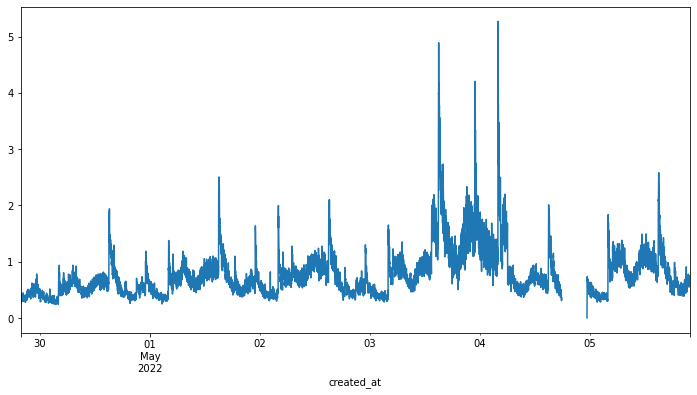

In [200]:
#plot the resampled tweet rate
resampled_tudf.mean()['tweet_rate_60'].plot(figsize=(12,6))


## seasonal decomposing


In [201]:
# just look at the resampled df
resampled_tudf.mean().dropna()

,tweet_rate_60,tweet_rate_600,time_since_last_tweet_rolling_60,time_since_last_tweet_rolling_600
created_at,,,,
2022-04-29 20:14:00+00:00,0.385661,0.359842,2.596000,2.779000
2022-04-29 20:15:00+00:00,0.401913,0.361531,2.492982,2.766053
2022-04-29 20:16:00+00:00,0.377319,0.363095,2.651754,2.754123
2022-04-29 20:17:00+00:00,0.338322,0.363912,2.962281,2.747982
2022-04-29 20:18:00+00:00,0.307473,0.364595,3.257778,2.742889
...,...,...,...,...
2022-05-05 21:55:00+00:00,0.688653,0.655620,1.453333,1.525292
2022-05-05 21:56:00+00:00,0.665937,0.649971,1.504687,1.538542
2022-05-05 21:57:00+00:00,0.573858,0.643458,1.744298,1.554123


### Decompose by day --- tweet rate 600

In [202]:
from statsmodels.tsa.seasonal import seasonal_decompose





decomp_date_end = datetime(2022, 5, 4, 12, 0, 0, tzinfo = UTC)

decomp = seasonal_decompose(resampled_tudf['tweet_rate_600'].mean().dropna(), period = 60*24)

# plt.rc('figure', figsize(12,6))
# decomp.plot();



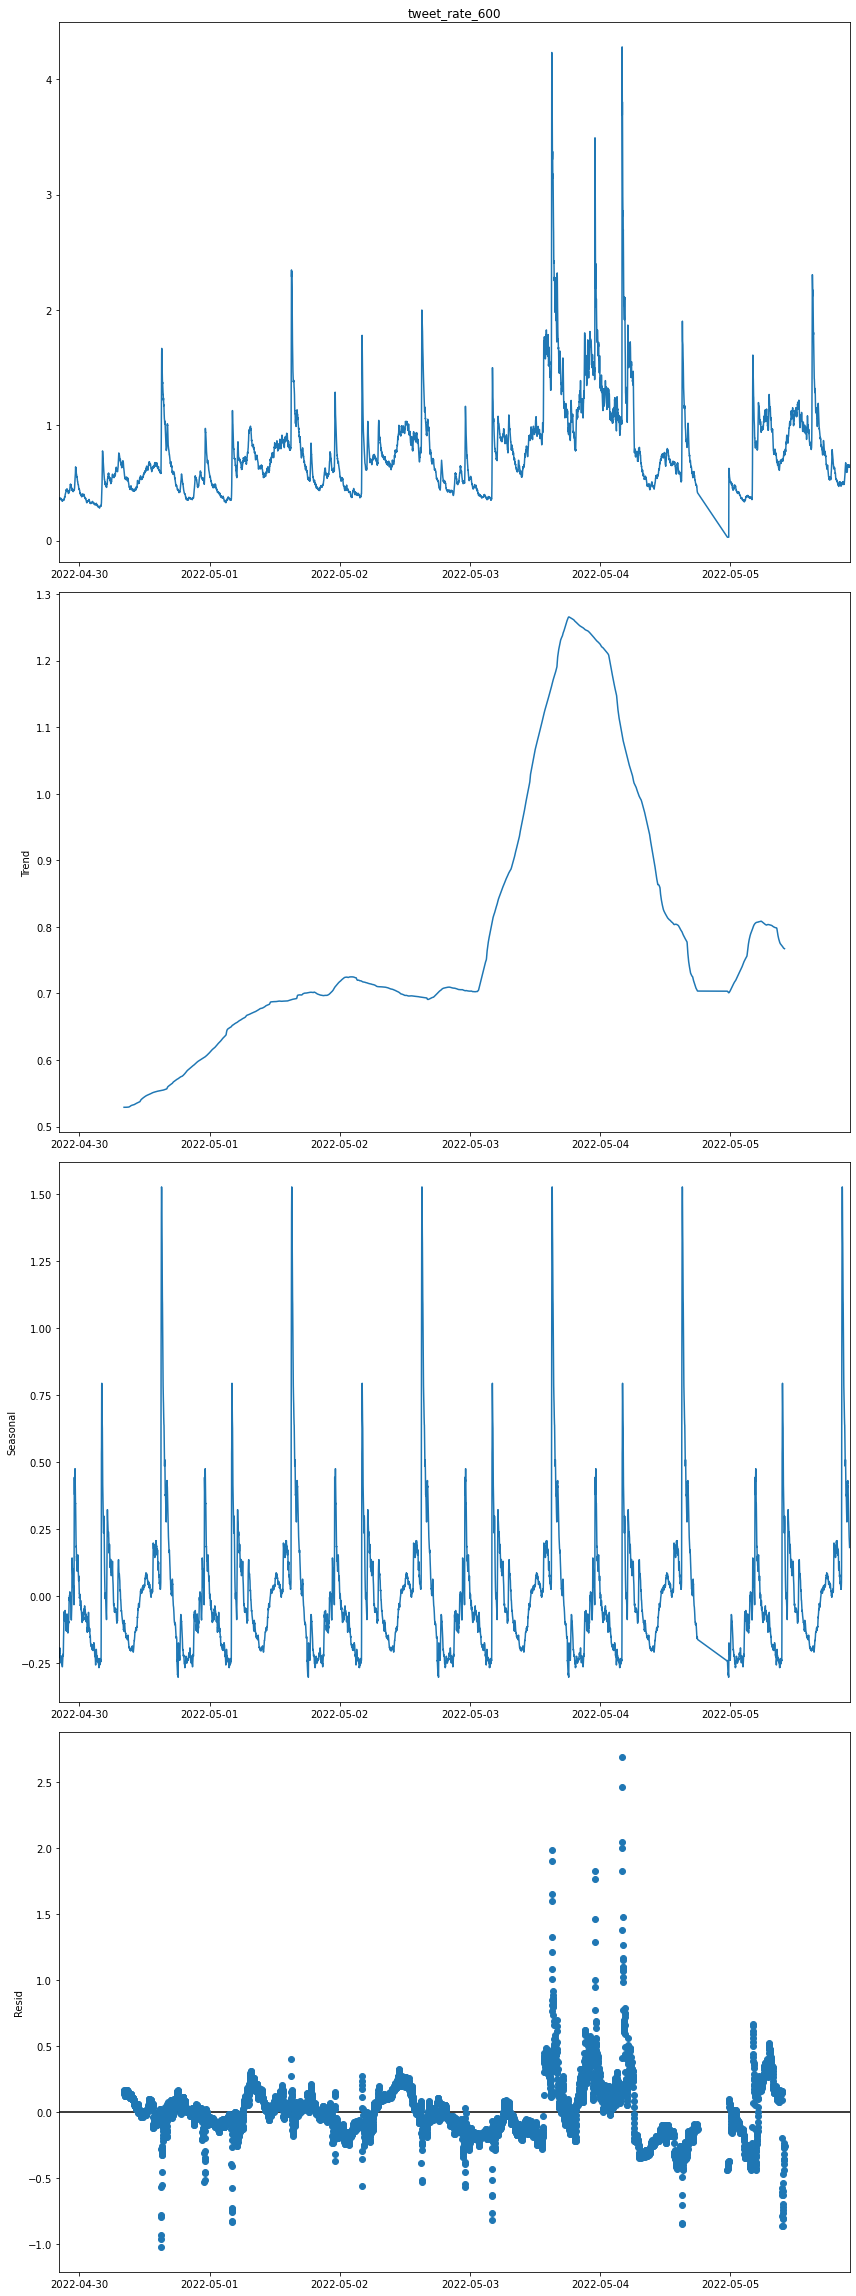

In [203]:
plt.rc('figure',figsize = (12,32))
decomp.plot();

### Decompose by hour --- tweet rate 600

In [204]:
decomp_date_end = datetime(2022, 5, 4, 12, 0, 0, tzinfo = UTC)
decomp = seasonal_decompose(resampled_tudf['tweet_rate_600'].mean().dropna(), period = 60)

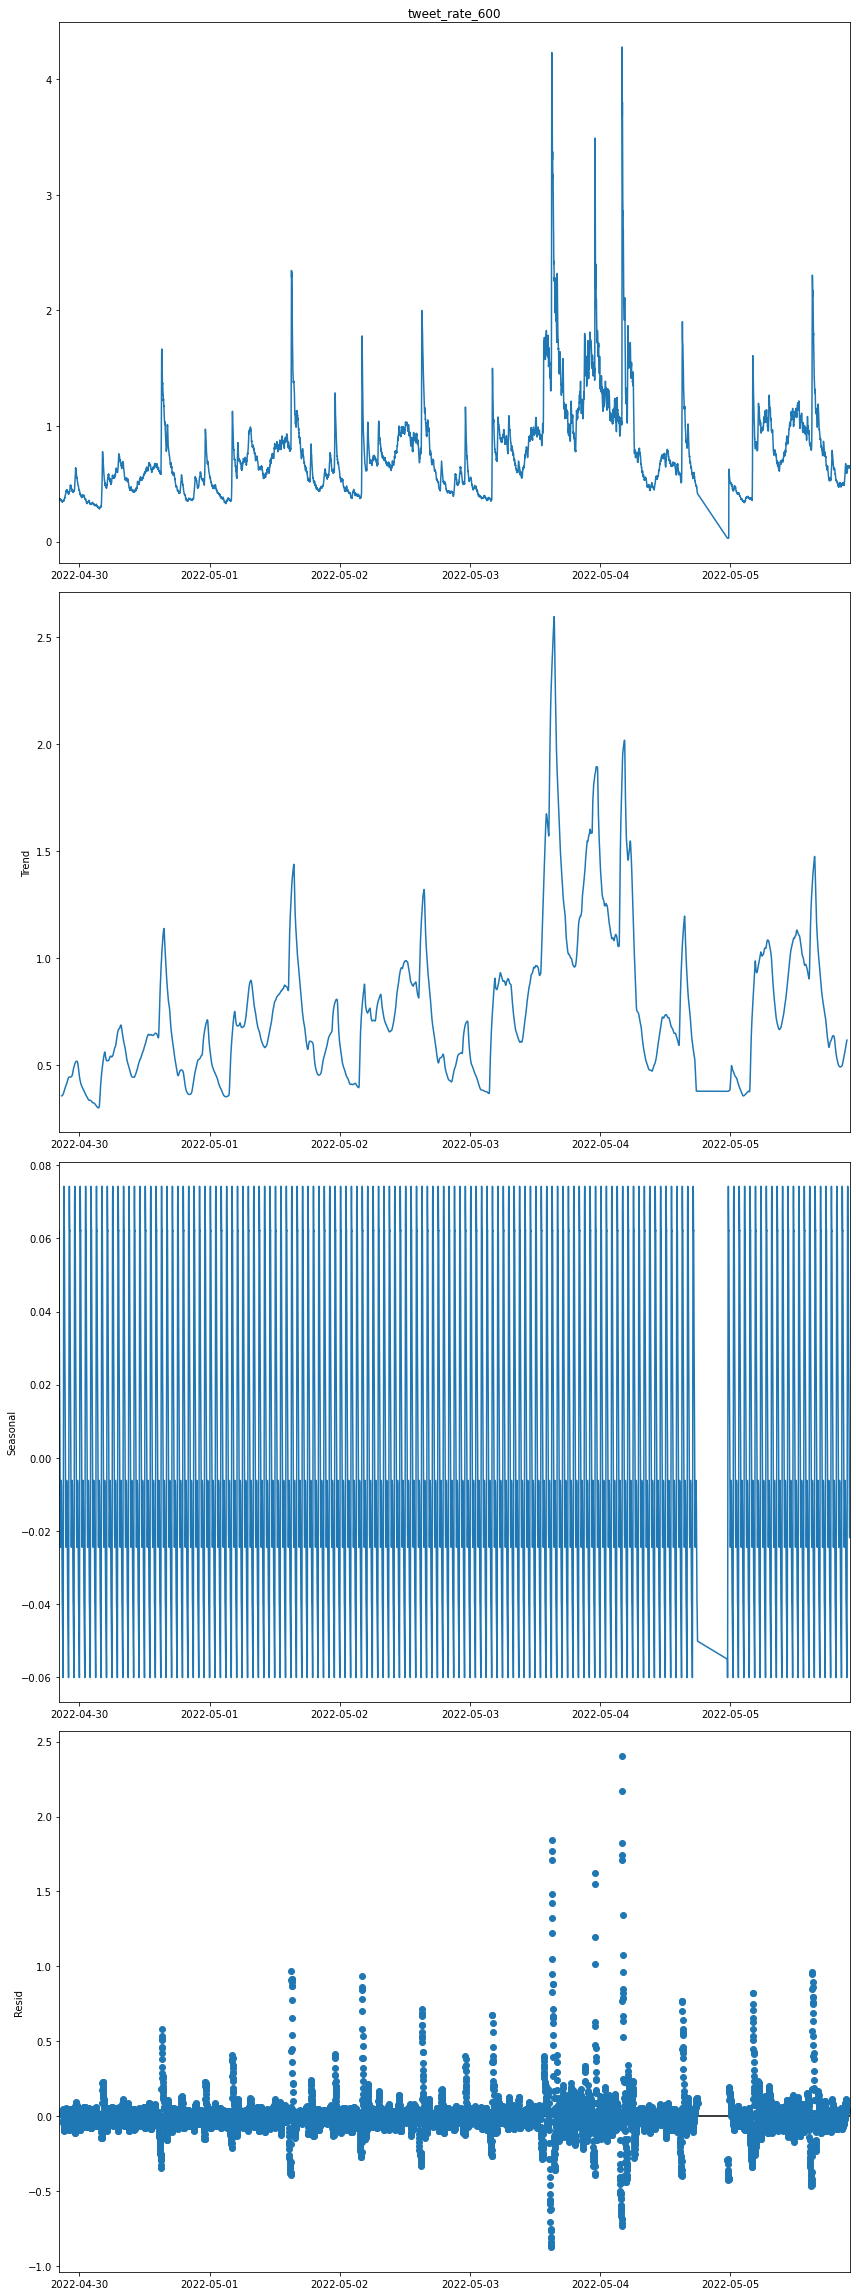

In [205]:
plt.rc('figure',figsize = (12,32))
decomp.plot();

### autocorrelation

In [206]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [207]:
resampled_tudf['tweet_rate_600'].mean().dropna()

created_at
2022-04-29 20:14:00+00:00    0.359842
2022-04-29 20:15:00+00:00    0.361531
2022-04-29 20:16:00+00:00    0.363095
2022-04-29 20:17:00+00:00    0.363912
2022-04-29 20:18:00+00:00    0.364595
                               ...   
2022-05-05 21:55:00+00:00    0.655620
2022-05-05 21:56:00+00:00    0.649971
2022-05-05 21:57:00+00:00    0.643458
2022-05-05 21:58:00+00:00    0.639689
2022-05-05 21:59:00+00:00    0.636048
Name: tweet_rate_600, Length: 8417, dtype: float64

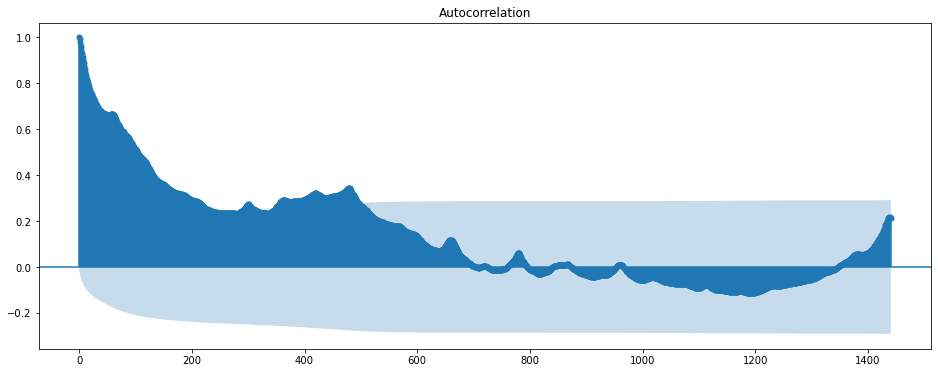

In [208]:
# Plot autocorrelation for lags up to one full day.
# There is a kink at 60 minutes, and at 23 and 24 hours.

plt.rc('figure',figsize = (16,6))
plot_acf(resampled_tudf['tweet_rate_600'].mean().dropna(), lags = 60*24);

### Partial autocorrelation


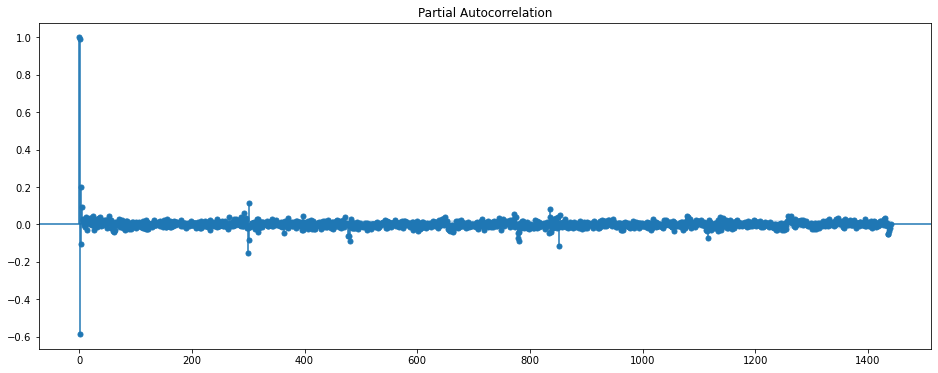

In [209]:
plt.rc('figure',figsize = (16,6))
plot_pacf(resampled_tudf['tweet_rate_600'].mean().dropna(), lags = 60*24);

(-0.15, 0.15)

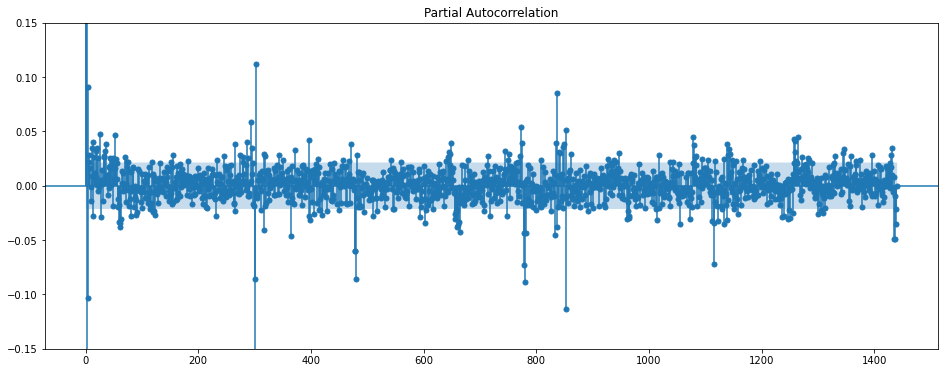

In [210]:
plt.rc('figure',figsize = (16,6))
pacf_plot = plot_pacf(resampled_tudf['tweet_rate_600'].mean().dropna(), lags = 60*24);
pacf_plot.axes[0].set_ylim([-0.15,0.15])

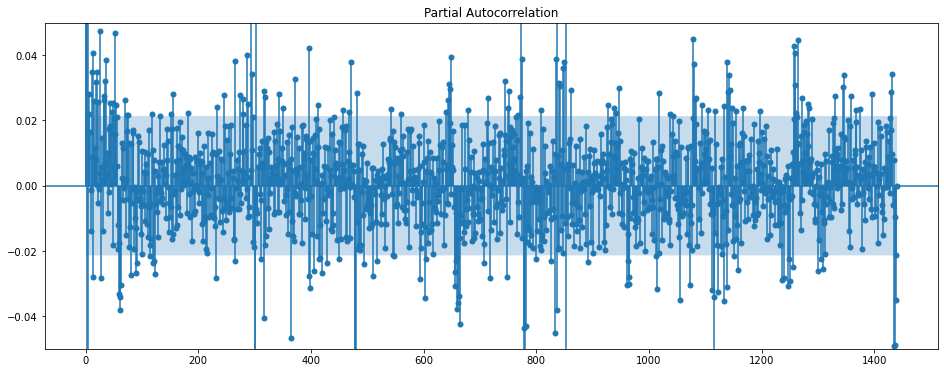

In [211]:
pacf_plot.axes[0].set_ylim([-0.05,0.05])
pacf_plot

In [212]:
# save time series data up to here for practice with time series models
resampled_tudf.mean().to_csv('../merged_data/resampled_tudf_minute_basic.csv', index = True)

In [213]:
resampled_tudf.mean().index

DatetimeIndex(['2022-04-29 19:46:00+00:00', '2022-04-29 19:47:00+00:00',
               '2022-04-29 19:48:00+00:00', '2022-04-29 19:49:00+00:00',
               '2022-04-29 19:50:00+00:00', '2022-04-29 19:51:00+00:00',
               '2022-04-29 19:52:00+00:00', '2022-04-29 19:53:00+00:00',
               '2022-04-29 19:54:00+00:00', '2022-04-29 19:55:00+00:00',
               ...
               '2022-05-05 21:50:00+00:00', '2022-05-05 21:51:00+00:00',
               '2022-05-05 21:52:00+00:00', '2022-05-05 21:53:00+00:00',
               '2022-05-05 21:54:00+00:00', '2022-05-05 21:55:00+00:00',
               '2022-05-05 21:56:00+00:00', '2022-05-05 21:57:00+00:00',
               '2022-05-05 21:58:00+00:00', '2022-05-05 21:59:00+00:00'],
              dtype='datetime64[ns, UTC]', name='created_at', length=8774, freq='60S')

# geo and location

`geo` is a geocode corresponding to a location. They are also called `place_id`. The great majority of tweets do not have a geo code. Location comes from the user data, rather than the tweet itself.

According to [Get information about a place](https://developer.twitter.com/en/docs/twitter-api/v1/geo/place-information/api-reference/get-geo-id-place_id) in the Twitter docs,
> These IDs can be retrieved from geo/reverse_geocode.

`location` is a very general string.

In [214]:
tudf.columns

Index(['conversation_id', 'reply_settings', 'lang', 'possibly_sensitive',
       'source', 'text', 'context_annotations', 'author_id', 'created_at',
       'referenced_tweets', 'in_reply_to_user_id', 'attachments', 'geo',
       'withheld_tweet', 'name', 'public_metrics_user', 'url', 'description',
       'profile_image_url', 'location', 'protected', 'username', 'verified',
       'entities_user', 'pinned_tweet_id', 'withheld_user',
       'entities_tweeturls', 'entities_tweetmentions',
       'entities_tweethashtags', 'entities_tweetannotations',
       'entities_tweetcashtags', 'public_metrics_tweetretweet_count',
       'public_metrics_tweetreply_count', 'public_metrics_tweetlike_count',
       'public_metrics_tweetquote_count', 'game', 'win', 'is_poke',
       'user_has_description', 'wordle_tweet_number', 'ones',
       'time_since_last_tweet', 'wordle_tweet_rate',
       'time_since_last_tweet_rolling_60', 'time_since_last_tweet_rolling_600',
       'tweet_rate_60', 'tweet_rate_6

In [215]:
tudf['geo'].value_counts()

{}                                  380358
{'place_id': '206c436ce43a43a3'}       148
{'place_id': '018f1cde6bad9747'}        86
{'place_id': '3797791ff9c0e4c6'}        64
{'place_id': '0161be1b3f98d6c3'}        48
                                     ...  
{'place_id': '5552c90a5411d6b2'}         1
{'place_id': '013522304ee10b39'}         1
{'place_id': '231af294750b236e'}         1
{'place_id': '699e7e72554fee2a'}         1
{'place_id': '019cbbb8154486f2'}         1
Name: geo, Length: 1762, dtype: int64

In [216]:
len(tudf)

386457

In [217]:
#she/her is a location according to 239 of these

In [218]:
tudf['location'].value_counts().loc['Irvine, CA']

23

In [219]:
tudf['location'].value_counts().iloc[-50:]

Richmond-Upon-Thames             1
Cuji, Canagaua / 그지, 가나가와        1
Houston, TX via Waterbury, CT    1
Athens, Attica                   1
16 . aesop ☍ they/them           1
Valloria, Soria                  1
Sandbach, England                1
London and Maidenhead            1
konya                            1
Poole, Dorset                    1
almería - granada                1
Sivakasi, Tamil Nadu, India      1
Rogano Oyster Bar, Glasgow       1
Swat/Islamabad                   1
Agüimes                          1
Tamworth, England                1
Currently In Kuala Lumpur        1
Lympsham, England                1
Jagera Yuggera Ugarapul Land     1
Snug as a bee bean               1
Bk                               1
London || Los Angeles            1
Illescas, España                 1
York YO32 9TW                    1
Zushi                            1
At Nearest Tea Stall             1
Mapperley, England               1
trying to find myself            1
Inca                

In [220]:
tudf['entities_user'].iloc[2]

'{}'

In [221]:
#export the list of unique locations
pd.Series(tudf['location'].value_counts().index).to_csv('unique_locations.csv')

#import dict of "binned" locations
loc_bin_path = './loc_dict.json'
with open(loc_bin_path, 'r') as file:
    locs = json.loads(file.read())
locs

{'United States': 'USA',
 'Los Angeles, CA': 'USA',
 'London': 'UK',
 'London, England': 'UK',
 'India': 'IN',
 'Chicago, IL': 'USA',
 '日本': 'JPN',
 'Canada': 'CA',
 'Madrid': 'ES',
 'New York, NY': 'USA',
 'she/her': 'GENDER',
 'United Kingdom': 'UK',
 'Japan': 'JPN',
 'Australia': 'ASTL',
 'Atlanta, GA': 'USAE',
 'California, USA': 'USAW',
 'UK': 'UK',
 'England, United Kingdom': 'UK',
 'España': 'ES',
 'Washington, DC': 'USAE',
 'USA': 'USA',
 'Toronto, Ontario': 'CAE',
 'Seattle, WA': 'USAW',
 'Tokyo': 'JPN',
 'Buenos Aires, Argentina': 'AR',
 'Ireland': 'IE',
 'Madrid, Comunidad de Madrid': 'ES',
 'Argentina': 'AR',
 '東京': 'JPN',
 'Florida, USA': 'USAE',
 'Brooklyn, NY': 'USAE',
 'Houston, TX': 'USAC',
 '東京都': 'JPN',
 'Philadelphia, PA': 'USAE',
 'Toronto': 'CAE',
 'New York, USA': 'USAE',
 'Melbourne, Victoria': 'ASTL',
 'Boston, MA': 'USAE',
 'Texas, USA': 'USAC',
 'Santiago, Chile': 'CL',
 'Mumbai, India': 'IN',
 'New York': 'USAE',
 'Austin, TX': 'USAC',
 'New Jersey, USA': 'U

In [222]:
len(locs)

997

This dictionary's keys are nearly 1000 of the top values found for `geo`. The values are broad regions, usually country. USA, Canada are divided into time zones according to some really good guesses.

In [223]:
[
    key 
    for key in locs.keys()
    if locs[key] == "CA"
]

['Canada', '🇨🇦', 'CA', 'Canada ', 'canada', 'Saskatchewan, Canada']

In [224]:
# look at the unique location values
set(locs.values())

{'',
 'AK',
 'AR',
 'ASTL',
 'AT',
 'AZR',
 'BA',
 'BAHR',
 'BO',
 'BR',
 'CA',
 'CAC',
 'CAE',
 'CAM',
 'CAT',
 'CAW',
 'CL',
 'CLEVER',
 'CO',
 'CR',
 'DE',
 'EC',
 'EG',
 'ELSL',
 'ES',
 'EUR',
 'Earth',
 'FR',
 'GENDER',
 'GH',
 'GHAN',
 'GUAT',
 'HI',
 'HK',
 'HO',
 'ID',
 'IE',
 'IL',
 'IN',
 'JAM',
 'JPN',
 'KE',
 'KOR',
 'KZ',
 'LEBN',
 'MLDV',
 'MX',
 'MY',
 'NEP',
 'NG',
 'NZ',
 None,
 'PA',
 'PARA',
 'PE',
 'PH',
 'PK',
 'PR',
 'PT',
 'RS',
 'RU',
 'SA',
 'SG',
 'SL',
 'TH',
 'TK',
 'TT',
 'TW',
 'UAE',
 'UK',
 'UR',
 'USA',
 'USAC',
 'USAE',
 'USAM',
 'USAW',
 'VA',
 'VE',
 'ZA',
 'ZM'}

In [225]:

tudf['broad_location'] = tudf['location'].apply(lambda this_location: locs[this_location] if this_location in locs.keys() else 'undefined')

In [226]:
# count the number of tweets covered by this dictionary
tudf['broad_location'].value_counts().head(20)

undefined    293109
USAE          15601
UK            10712
JPN            7718
ES             7507
USAC           6573
USA            5562
USAW           4859
IN             4297
ASTL           3281
CAE            2457
AR             2066
GENDER         1638
USAM           1580
IE             1334
CLEVER         1305
TK             1304
CA              947
MX              869
PH              861
Name: broad_location, dtype: int64

In [227]:
defined_loc_num = len(tudf[tudf['broad_location'] != 'undefined']) 
tudf_size = len(tudf)
print(f'{"{0:.1f}%".format(100*defined_loc_num/tudf_size)} == {defined_loc_num}/{tudf_size}.')

24.2% == 93348/386457.


A bit less than 1/4 of the tweets have associated users who gave their location in one of these top categories. One out of four giving a general location is still valuable. By far, and unsurprisingly, the USA and UK are in the top. Wordle is an English language game. But Japan follows, with many Pokemon Worlders, as well as Spain, which appears to having its own popular Wordle variant in Spanish. India, Australia, Canada, Argentina, Ireland, Turkey, Mexico, and the Phillipines are all in the top 20.

English and Japanese users like to write a few "clever" common locations, such as "in bed", "at home." All of the Japanese ones are assigned a location of Japan, as it's a good bet someone writing in Japanese is from Japan. English is more widespread, so it is harder to assign a single location to these clever ones.

It is common in a few languages to write general locations like "Earth", or "the galaxy." These are funneled into "Earth" in the dictionary, but will be ultimately given undefined status along with "clever"s for assigning a location.

Some people put pronouns in their location spot. These were assigned "GENDER" location. These as well will be given an "undefined" broad location. They could be valuable demographic information.

In [228]:
#send clevers to undefined
tudf[tudf['broad_location'] == 'CLEVER'] = 'undefined'

#send earths to undefined
tudf[tudf['broad_location'] == 'Earth'] = 'undefined'

#send genders to undefined
tudf[tudf['broad_location'] == 'GENDER'] = 'undefined'

In [238]:
loc_vcs = tudf['broad_location'].value_counts()

In [242]:
loc_vcs.index

Index(['undefined', 'USAE', 'UK', 'JPN', 'ES', 'USAC', 'USA', 'USAW', 'IN',
       'ASTL', 'CAE', 'AR', 'USAM', 'IE', 'TK', 'CA', 'MX', 'PH', 'NZ', 'CL',
       'SA', 'EUR', 'CAW', 'MY', 'CAM', 'CO', 'ID', 'DE', 'TH', 'FR', 'KOR',
       'SG', 'PK', 'PE', 'KE', 'UR', 'EG', 'TT', 'NG', 'JAM', 'TW', 'CAC',
       'BR', 'VE', 'CAT', 'HK', 'PA', 'UAE', 'CR', 'PARA', 'GUAT', 'EC', 'AT',
       'SL', 'HI', 'IL', 'ELSL', 'BO', 'VA', 'BA', 'LEBN', 'MLDV', 'KZ', 'HO',
       'NEP', 'AZR', 'BAHR', 'ZA', 'GHAN', 'RU', 'RS', 'ZM', 'AK', 'PT', 'PR',
       'GH', ''],
      dtype='object')

In [244]:
loc_vcs.values

array([296667,  15601,  10712,   7718,   7507,   6573,   5562,   4859,
         4297,   3281,   2457,   2066,   1580,   1334,   1304,    947,
          869,    861,    795,    793,    789,    765,    649,    559,
          520,    519,    496,    453,    410,    367,    344,    314,
          246,    243,    241,    230,    221,    206,    185,    184,
          168,    160,    160,    158,    154,    151,    143,    141,
          134,    101,     96,     95,     90,     84,     82,     62,
           57,     54,     43,     42,     40,     40,     38,     35,
           34,     34,     34,     33,     32,     29,     29,     28,
           28,     27,     24,     24,     23], dtype=int64)

In [239]:
#look at remaining top broad locations
tudf['broad_location'].value_counts().head(50)

undefined    296667
USAE          15601
UK            10712
JPN            7718
ES             7507
USAC           6573
USA            5562
USAW           4859
IN             4297
ASTL           3281
CAE            2457
AR             2066
USAM           1580
IE             1334
TK             1304
CA              947
MX              869
PH              861
NZ              795
CL              793
SA              789
EUR             765
CAW             649
MY              559
CAM             520
CO              519
ID              496
DE              453
TH              410
FR              367
KOR             344
SG              314
PK              246
PE              243
KE              241
UR              230
EG              221
TT              206
NG              185
JAM             184
TW              168
CAC             160
BR              160
VE              158
CAT             154
HK              151
PA              143
UAE             141
CR              134
PARA            101


<BarContainer object of 19 artists>

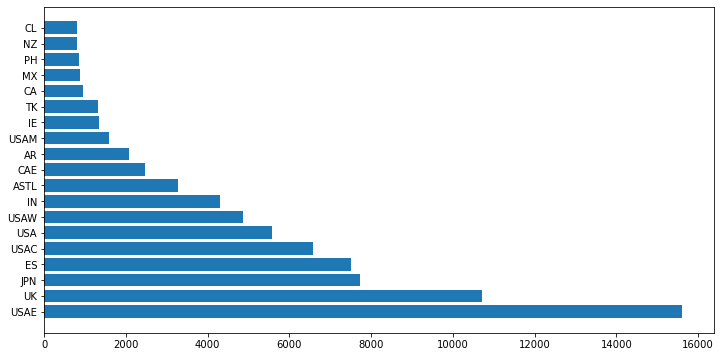

In [249]:
#linear plot of broad locations
plt.figure(figsize = (12,6))
plt.barh(width = loc_vcs.values[1:20], y = loc_vcs.index[1:20])

<BarContainer object of 25 artists>

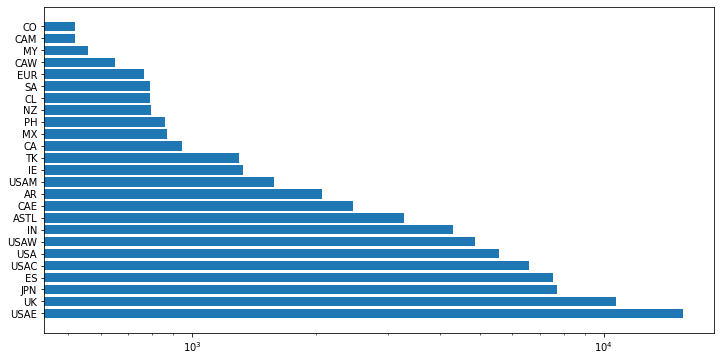

In [258]:
#log plot of broad locations
plt.figure(figsize = (12,6))
plt.barh(width = loc_vcs.values[1:26], y = loc_vcs.index[1:26], log = True)

In the preprocessing stage, these will be turned into booleans for the model to grab onto.

# User `entities`

I've called them `entities_user` in the merged df.

In [251]:
tudf.columns

Index(['conversation_id', 'reply_settings', 'lang', 'possibly_sensitive',
       'source', 'text', 'context_annotations', 'author_id', 'created_at',
       'referenced_tweets', 'in_reply_to_user_id', 'attachments', 'geo',
       'withheld_tweet', 'name', 'public_metrics_user', 'url', 'description',
       'profile_image_url', 'location', 'protected', 'username', 'verified',
       'entities_user', 'pinned_tweet_id', 'withheld_user',
       'entities_tweeturls', 'entities_tweetmentions',
       'entities_tweethashtags', 'entities_tweetannotations',
       'entities_tweetcashtags', 'public_metrics_tweetretweet_count',
       'public_metrics_tweetreply_count', 'public_metrics_tweetlike_count',
       'public_metrics_tweetquote_count', 'game', 'win', 'is_poke',
       'user_has_description', 'wordle_tweet_number', 'ones',
       'time_since_last_tweet', 'wordle_tweet_rate',
       'time_since_last_tweet_rolling_60', 'time_since_last_tweet_rolling_600',
       'tweet_rate_60', 'tweet_rate_6

In [252]:
#the .replace("'", '"')
# must be done to replace single quotes with double quotes. otherwise it's not JSON.
json.loads(tudf['entities_user'].iloc[1].replace("'", '"'))

{'url': {'urls': [{'start': 0,
    'end': 23,
    'url': 'https://t.co/OqVqYWdqMx',
    'expanded_url': 'http://www.carlygarza.com/links',
    'display_url': 'carlygarza.com/links'}]},
 'description': {'mentions': [{'start': 89,
    'end': 105,
    'username': 'brickatbluestar'},
   {'start': 108, 'end': 119, 'username': 'carlygarza'},
   {'start': 122, 'end': 138, 'username': 'shopcakeforever'}]}}

### verified

In [254]:
tudf[tudf['verified'] == True]

,conversation_id,reply_settings,lang,possibly_sensitive,source,text,context_annotations,author_id,created_at,referenced_tweets,in_reply_to_user_id,attachments,geo,withheld_tweet,name,public_metrics_user,url,description,profile_image_url,location,protected,username,verified,entities_user,pinned_tweet_id,withheld_user,entities_tweeturls,entities_tweetmentions,entities_tweethashtags,entities_tweetannotations,entities_tweetcashtags,public_metrics_tweetretweet_count,public_metrics_tweetreply_count,public_metrics_tweetlike_count,public_metrics_tweetquote_count,game,win,is_poke,user_has_description,wordle_tweet_number,ones,time_since_last_tweet,wordle_tweet_rate,time_since_last_tweet_rolling_60,time_since_last_tweet_rolling_600,tweet_rate_60,tweet_rate_600,broad_location
1520128996435976193,1520128996435976193,everyone,en,False,Twitter for iPhone,Wordle 314 5/6\n\n⬛🟨⬛⬛⬛\n⬛⬛🟩⬛🟩\n⬛⬛🟩🟨🟩\n⬛🟩🟩⬛🟩\n...,"[{'domain': {'id': '30', 'name': 'Entities [En...",21126964,2022-04-29 19:52:50+00:00,[],0.0,{},{},{},Quinton Martinez,"{'followers_count': 5285, 'following_count': 3...",https://t.co/N9AVjVzyX0,"Husband to Eva, Father of Penelope. Mild-manne...",https://pbs.twimg.com/profile_images/378800000...,"Corpus Christi, TX",False,qmartinez,True,"{'url': {'urls': [{'start': 0, 'end': 23, 'url...",0.0,{},NaN,NaN,NaN,NaN,NaN,0,0,0,0,NaN,False,False,True,107,1.0,1.0,1.0,3.116667,NaN,0.320856,NaN,undefined
1520131320323604480,1520120660642525184,everyone,en,False,TweetDeck,@cgboan I always appreciate some good Trevor B...,"[{'domain': {'id': '3', 'name': 'TV Shows', 'd...",340420393,2022-04-29 20:02:04+00:00,"[{'type': 'replied_to', 'id': '152012066064252...",1961379848.0,{},{},{},Luke Thompson,"{'followers_count': 2340, 'following_count': 5...",https://t.co/Oi6PpcR8Lt,@Yakima_Herald outdoors/sports reporter. Socce...,https://pbs.twimg.com/profile_images/122443793...,"Yakima, WA",False,LukeTScribe,True,"{'url': {'urls': [{'start': 0, 'end': 23, 'url...",0.0,{},NaN,"[{'start': 0, 'end': 7, 'username': 'cgboan', ...",NaN,"[{'start': 38, 'end': 49, 'probability': 0.990...",NaN,0,1,1,0,NaN,False,False,True,312,1.0,5.0,0.2,2.566667,NaN,0.38961,NaN,undefined
1520131823170428930,1520131823170428930,everyone,en,False,Twitter for iPhone,Wordle (ES) #113 3/6\n\n⬜⬜⬜⬜🟩\n⬜🟨🟩⬜🟩\n🟩🟩🟩🟩🟩\n...,"[{'domain': {'id': '30', 'name': 'Entities [En...",470448667,2022-04-29 20:04:03+00:00,[],0.0,{},{'place_id': '8f754c4539126636'},{},Javier Pagán,"{'followers_count': 1798, 'following_count': 1...",,Having fun and working hard at @TwitterEspana,https://pbs.twimg.com/profile_images/135962418...,Madrid,False,JavierPagan76,True,"{'description': {'mentions': [{'start': 31, 'e...",0.0,{},"[{'start': 42, 'end': 65, 'url': 'https://t.co...",NaN,NaN,NaN,NaN,0,0,1,0,NaN,False,False,True,358,1.0,4.0,0.25,2.65,NaN,0.377358,NaN,ES
1520132947210211330,1520132947210211330,everyone,en,False,Twitter for iPhone,Wordle 314 6/6\n\n🟨⬛⬛⬛⬛\n⬛⬛🟩⬛🟨\n🟨⬛🟩⬛⬛\n⬛⬛🟩⬛⬛\n...,"[{'domain': {'id': '30', 'name': 'Entities [En...",5417332,2022-04-29 20:08:31+00:00,[],0.0,{},{},{},Joshua Hale Fialkov,"{'followers_count': 11947, 'following_count': ...",https://t.co/ebD71SlF5v,"Maker of TV, Comics (THE BUNKER, THE LIFE AFTE...",https://pbs.twimg.com/profile_images/145088114...,"North Hollywood, CA",False,JoshFialkov,True,"{'url': {'urls': [{'start': 0, 'end': 23, 'url...",1490959869930663936.0,{},NaN,NaN,NaN,NaN,NaN,0,0,0,0,NaN,False,False,True,453,1.0,0.0,inf,2.3,NaN,0.434783,NaN,undefined
1520136221569085440,1520136221569085440,everyone,en,False,Twitter for Android,Wordle 315 6/6\n\n⬛🟩⬛⬛⬛\n⬛⬛⬛⬛⬛\n⬛🟩🟩⬛⬛\n⬛🟩🟩⬛⬛\n...,"[{'domain': {'id': '30', 'name': 'Entities [En...",217124128,2022-04-29 20:21:32+00:00,[],0.0,{},{},{},Krishna Chandra (KC),"{'followers_count': 1382, 'following_count': 8...",https://t.co/DxROBp5WW4,Editor @Reuters. Bookworm. @Arsenal Addict. Te...,https://pbs.twimg.com/profile_images/144014365...,India,False,krishna_eluri,True,"{'url': {'urls': [{'start': 0, 'end': 23, 'url...",0.0,{},NaN,NaN,NaN,NaN,NaN,0

# Export for preprocessing

choosing columns to build a model with.

reply_settings will lead to overfitting. perhaps also with replies, etc.
anything that favors a small number of individual tweets or users with high influence will cause overfitting.


- lang
- possibly sensitive
    seems to have a relationship with location. specific sites.
- source
    make top sources
- text
- created_at
- location
- game
- win
- is_poke
- broad location
- hashtags
- has_hashtags

In [320]:
save_these_cols = [
    'lang',
    'possibly_sensitive',
    'source',
    'text',
    'created_at',
    'location',
    'game',
    'win',
    'is_poke',
    'broad_location',
    'hashtags',
    'has_hashtags'
]

In [322]:
#export these columns
data_for_preprocessing_path = '../merged_data/data_for_preprocessing.csv'
tudf[save_these_cols].to_csv(data_for_preprocessing_path)